### Proximal Gradient Method

#### 1. [4 points] Write down exact formulation of subgradient method and proximal gradient method here (you can not use any optimization problems in this formulation).

$$L=-\frac{1}{N}\sum_{i=1}^{N} \log P(y_i | x_i; W) + \lambda \| W \|_1 \to\min_{W \in \mathbb{R}^{c \times d}} $$

Немного перепишем лосс, чтобы было удобно считать градиент по матрице $W$

$$L = -\frac{1}{N}\sum_{i=1}^{N} \log P(y_i | x_i; W) + \lambda \| W \|_1  = -\frac{1}{N}\sum_{i=1}^{N} \log \frac{e^{W_{y_j}^T x_i}}{\sum\limits_{i=1}^{c} e^{W_{y_j}^T x_i}}+ \lambda \| W \|_1 = -\frac{1}{N}\sum_{i=1}^{N} \log e^{W_{y_j}^T x_i} - \frac{1}{N}\sum_{i=1}^{N}\log\sum\limits_{i=1}^{c} e^{W_{y_j}^T x_i}+ \lambda \| W \|_1 =$$

Теперь избавимся от $W_{y_j}$. Для этого будет использовать доп матрицу, каждый столбец которой -- это вектор из всех нулей и единички, которая стоит на месте правильного класса.

$$=-\frac{1}{N}\sum_{i=1}^{N} \log e^{W_{y_j}^T x_i} - \frac{1}{N}\sum_{i=1}^{N}\log\sum\limits_{i=1}^{c} e^{W_{y_j}^T x_i}+ \lambda \| W \|_1 =-\frac{1}{N}\sum_{i=1}^{N} v_i^{\top}W x_i - \frac{1}{N}\sum_{i=1}^{N}\log \mathbb{1}e^{W x_i} + \lambda \| W \|_1 $$

Теперь берём градиент по первым двум слагаемым и субградиент по последнему

$$\nabla_W\left(-\frac{1}{N}\sum_{i=1}^{N} v_i^{\top}W x_i\right) = -\frac{1}{N}\sum_{i=1}^{N} \nabla_W(v_i^{\top}W x_i) = -\frac{1}{N}\sum_{i=1}^{N} x_iv_i^{\top}$$

$$\nabla_W\left(- \frac{1}{N}\sum_{i=1}^{N}\log \mathbb{1}e^{W x_i}\right) = - \frac{1}{N}\sum_{i=1}^{N}\nabla_W\log \mathbb{1}e^{W x_i}=- \frac{1}{N}\sum_{i=1}^{N}\frac{\nabla_W \mathbb{1}e^{W x_i}}{\mathbb{1}e^{W x_i}} = - \frac{1}{N}\sum_{i=1}^{N}\frac{x_ie^{W x_i}}{\mathbb{1}e^{W x_i}} $$

$$\partial_W(\lambda \| W \|_1) = \lambda \sdot\text{sign}(W)$$

Итого шаг субградиентного спуска выглядит так:

$$W_{k+1} = W_k - \alpha \left(-\frac{1}{N}\sum_{i=1}^{N} x_iv_i^{\top} - \frac{1}{N}\sum_{i=1}^{N}\frac{x_ie^{W x_i}}{\mathbb{1}e^{W x_i}} + \lambda \sdot\text{sign}(W)\right)$$

Теперь разберёмся с проксимальным методом. С лекции знаем, что $$\text{prox}_{\lambda \|W\|_1}(x) = [|x| - \lambda]_+ \cdot\text{sign}(x)$$

Тогда шаг будет выглядить как

$$W_{k+1} = \left[\left|W_k - \alpha \left(-\frac{1}{N}\sum_{i=1}^{N} x_iv_i^{\top} - \frac{1}{N}\sum_{i=1}^{N}\frac{x_ie^{W x_i}}{\mathbb{1}e^{W x_i}}\right)\right| - \lambda\right]_+ \cdot\text{sign}\left(W_k - \alpha \left(-\frac{1}{N}\sum_{i=1}^{N} x_iv_i^{\top} - \frac{1}{N}\sum_{i=1}^{N}\frac{x_ie^{W x_i}}{\mathbb{1}e^{W x_i}}\right)\right)$$


#### 2. [6 points] Choose $\lambda = 0$. Solve the softmax regression problem using subgradient descent and proximal gradient descent. Find the highest learning (individually), acceptable for both methods to converge. Note, that if method assumes monotonic convergence - you have to choose appropriate learning rate to fullfill it. Report convergence curves and report final sparsity of both methods. Draw you conclusions.

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
import jax
from jax import numpy as jnp, grad
from scipy.optimize import minimize_scalar
import jax.numpy as jnp
from jax import grad, jit, hessian
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import time
from ucimlrepo import fetch_ucirepo
from scipy.special import softmax

def ReLU(x):
    return x * (x > 0)

# Define softmax function
@jit
def softmax(z):
    exp_z = jnp.exp(z - jnp.max(z, axis=1, keepdims=True))
    return exp_z / exp_z.sum(axis=1, keepdims=True)

# Define cross-entropy loss
@jit
def cross_entropy_loss_log(w, X, y):
    predictions = X @ w
    n = len(X)
    log_likelihoods = jax.scipy.special.logsumexp(predictions, axis=1)
    cross_entropy = log_likelihoods - jnp.sum(jnp.multiply(predictions, y), axis=1)
    return (1/n) * jnp.sum(cross_entropy)

# Set a random seed for reproducibility
np.random.seed(228)
jax.random.PRNGKey(228)

def compute_optimal(X, y, lam):
    n, d = X.shape
    k = y.shape[1]  # Assuming y is one-hot encoded, number of classes

    # Define the variable for weights
    w = cp.Variable((d, k))
    
    # Construct the objective
    logits = X @ w
    log_likelihoods = cp.log_sum_exp(logits, axis=1)
    cross_entropy_loss = cp.sum(log_likelihoods) - cp.sum(cp.multiply(y, logits))
    
    # Add l1 regularization
    l1_reg = lam * cp.sum(cp.abs(w))
    
    # Total loss
    loss = (1/n) * cross_entropy_loss + l1_reg
    
    # Define the problem
    problem = cp.Problem(cp.Minimize(loss))
    
    # Solve the problem
    problem.solve()
    
    # Extract the optimal weights and minimum loss
    w_star = w.value
    f_star = problem.value
    
    return w_star, f_star

def generate_problem():
    # Fetch dataset from UCI repository
    dataset = fetch_ucirepo(id=697)
    
    # Extract features and targets
    X = dataset.data.features.values
    y = dataset.data.targets.values.flatten()

    # Create a mapping from unique labels to integers
    unique_labels = np.unique(y)
    num_classes = len(unique_labels)
    label_to_int = {label: idx for idx, label in enumerate(unique_labels)}

    # Convert labels to integers using the mapping
    y_integers = jnp.array([label_to_int[label] for label in y])

    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y_integers, test_size=0.33, random_state=42)

    # Normalize the data
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # One-hot encoding using jax
    y_train_one_hot = jax.nn.one_hot(y_train, num_classes)
    y_test_one_hot = jax.nn.one_hot(y_test, num_classes)

    return X_train, y_train_one_hot, X_test, y_test_one_hot

def subgradient_descent(w_0, X, y, learning_rate=0.01, num_iters=100, lam=1):
    trajectory = [w_0]
    times = [0]
    w = w_0
    f = lambda w: cross_entropy_loss_log(w, X, y)
    xv = X.T @ y

    iter_start = time.time()
    for i in range(num_iters):
        Xw = X @ w
        w -= learning_rate * (- xv / X.shape[0] + X.T @ softmax(Xw) / X.shape[0] + lam * np.sign(w))
        # w -= learning_rate * (jax.grad(f)(w) + lam * np.sign(w))
        iter_time = time.time()
        trajectory.append(w)
        times.append(iter_time - iter_start)
    return trajectory, times


def proximal_gradient_method(w_0, X, y, learning_rate=0.01, num_iters=100, lam=1):
    trajectory = [w_0]
    times = [0]
    w = w_0
    f = lambda w: cross_entropy_loss_log(w, X, y) 
    xv = X.T @ y

    iter_start = time.time()
    for i in range(num_iters):
        Xw = X @ w
        step = w - learning_rate * (- xv / X.shape[0] + X.T @ softmax(Xw) / X.shape[0])
        # step = w - learning_rate * jax.grad(f)(w)
        w = ReLU(np.abs(step) - lam) * np.sign(step)
        iter_time = time.time()
        trajectory.append(w)
        times.append(iter_time - iter_start)
    return trajectory, times

# Compute accuracy
def compute_accuracy(w, X, y):
    predictions = softmax(X @ w)
    predicted_classes = jnp.argmax(predictions, axis=1)
    true_classes = jnp.argmax(y, axis=1)
    accuracy = jnp.mean(predicted_classes == true_classes)
    return accuracy

# Compute metrics
def compute_metrics(trajectory, x_star, f_star, times, X_train, y_train, X_test, y_test, lam):
    f = lambda w: cross_entropy_loss_log(w, X_train, y_train) + lam * jnp.sum(jnp.abs(w))
    metrics = {
        "f_gap": [jnp.abs(f(x) - f_star) for x in trajectory],
        "x_gap": [jnp.linalg.norm(x - x_star) for x in trajectory],
        "time": times,
        "train_acc": [compute_accuracy(x, X_train, y_train) for x in trajectory],
        "test_acc": [compute_accuracy(x, X_test, y_test) for x in trajectory],
        "sparsity": [jnp.mean(jnp.abs(x) < 1e-5) for x in trajectory]
    }
    return metrics

def run_experiments(params):
    lam = params["lam"]
    methods = params["methods"]
    results = {}

    X_train, y_train, X_test, y_test = generate_problem()
    n_features = X_train.shape[1]
    n_classes = len(y_train[0])
    params["n_features"], params["n_classes"] = n_features, n_classes
    
    x_0 = jax.random.normal(jax.random.PRNGKey(0), (n_features, n_classes))
    x_star, f_star = compute_optimal(X_train, y_train, lam)
    print(f"Optimal accuracy {compute_accuracy(x_star, X_train, y_train)}")

    for method in methods:
        if method["method"] == "Subgrad":
            learning_rate = method["learning_rate"]
            iterations = method["iterations"]
            trajectory, times = subgradient_descent(x_0, X_train, y_train, learning_rate, iterations, lam)
            label = method["method"] + f" lr {learning_rate:.2f}"
            results[label] = compute_metrics(trajectory, x_star, f_star, times, X_train, y_train, X_test, y_test, lam)
        elif method["method"] == "Proximal":
            learning_rate = method["learning_rate"]
            iterations = method["iterations"]
            trajectory, times = proximal_gradient_method(x_0, X_train, y_train, learning_rate, iterations, lam)
            label = method["method"] + f" lr {learning_rate:.2f}"
            results[label] = compute_metrics(trajectory, x_star, f_star, times, X_train, y_train, X_test, y_test, lam)

    return results, params

def plot_results(results, params):
    plt.figure(figsize=(11, 5))
    lam = params["lam"]
    
    plt.suptitle(f"Convex multiclass regression. lam={lam}.")

    plt.subplot(2, 4, 1)
    for method, metrics in results.items():
        plt.plot(metrics['f_gap'])
    plt.xlabel('Iteration')
    plt.ylabel(r'$|f(x) -f^*|$')
    plt.yscale('log')
    plt.grid(linestyle=":")

    plt.subplot(2, 4, 2)
    for method, metrics in results.items():
        plt.plot(metrics['x_gap'], label=method + f" sparsity {metrics['sparsity'][-1]:.3f}")
    plt.xlabel('Iteration')
    plt.ylabel('$\|x_k - x^*\|$')
    plt.yscale('log')
    plt.grid(linestyle=":")

    plt.subplot(2, 4, 3)
    for method, metrics in results.items():
        plt.plot(metrics["train_acc"])
    plt.xlabel('Iteration')
    plt.ylabel('Train accuracy')
    # plt.yscale('log')
    plt.grid(linestyle=":")

    plt.subplot(2, 4, 4)
    for method, metrics in results.items():
        plt.plot(metrics["test_acc"])
    plt.xlabel('Iteration')
    plt.ylabel('Test accuracy')
    # plt.yscale('log')
    plt.grid(linestyle=":")

    plt.subplot(2, 4, 5)
    for method, metrics in results.items():
        plt.plot(metrics["time"], metrics['f_gap'])
    plt.xlabel('Time')
    plt.ylabel(r'$|f(x) -f^*|$')
    plt.yscale('log')
    plt.grid(linestyle=":")

    plt.subplot(2, 4, 6)
    for method, metrics in results.items():
        plt.plot(metrics["time"], metrics['x_gap'])
    plt.xlabel('Time')
    plt.ylabel('$\|x_k - x^*\|$')
    plt.yscale('log')
    plt.grid(linestyle=":")

    plt.subplot(2, 4, 7)
    for method, metrics in results.items():
        plt.plot(metrics["time"], metrics["train_acc"])
    plt.xlabel('Time')
    plt.ylabel('Train accuracy')
    # plt.yscale('log')
    plt.grid(linestyle=":")

    plt.subplot(2, 4, 8)
    for method, metrics in results.items():
        plt.plot(metrics["time"], metrics["test_acc"])
    plt.xlabel('Time')
    plt.ylabel('Test accuracy')
    # plt.yscale('log')
    plt.grid(linestyle=":")

    # Place the legend below the plots
    plt.figlegend(loc='lower center', ncol=5, bbox_to_anchor=(0.5, -0.00))
    # Adjust layout to make space for the legend below
    filename = ""
    for method, metrics in results.items():
        filename += method
    filename += f"_{lam}.pdf"
    plt.tight_layout(rect=[0, 0.05, 1, 1])
    plt.savefig(filename)
    plt.show()

Optimal accuracy 0.7817139029502869


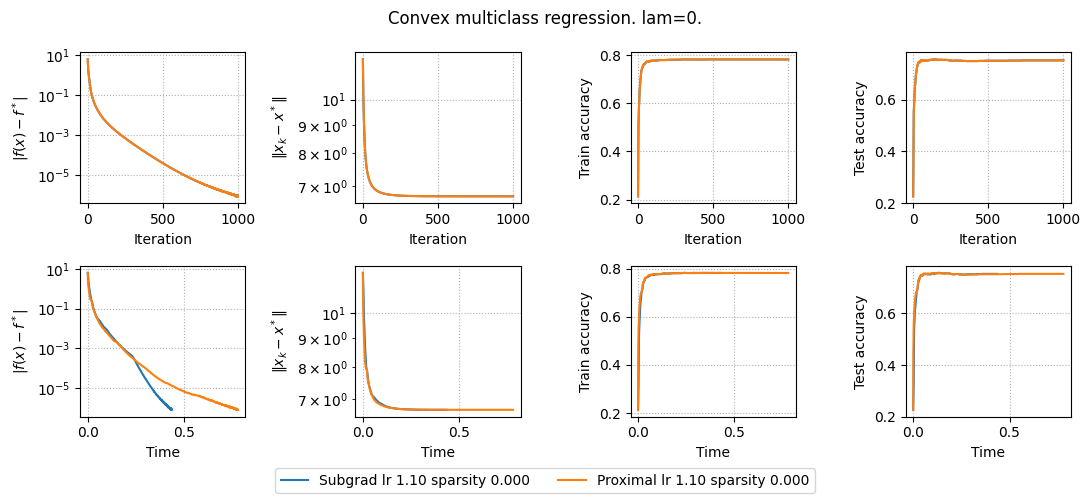

In [55]:
params = {
    "lam": 0,
    "methods": [
        {
            "method": "Subgrad",
            "learning_rate": 1.1,
            "iterations": 1000,
        },
        {
            "method": "Proximal",
            "learning_rate": 1.1,
            "iterations": 1000,
        },
    ]
}

results, params = run_experiments(params)
plot_results(results, params)

Если увеличивать lr, то монотонная сходимость пропадает, появляются колебания.

#### 3. [10 points] Solve non-smooth problem and fill the following table. For each value of $\lambda$ provide convergence curves.

| Method | Learning Rate ($\eta$) | Tolerance ($\epsilon$) | Number of Iterations|Comment(if any)|Final Sparsity of the solution|$\lambda$|Final test accuracy
| --- | ----------- |   ----------- |----------- |----------- |----------- |----------- |----------- |
| Subgradient Descent | 1 | $10^{-1}$ |100 |No |0 |1e-2 |0.77 |
| Subgradient Descent | 1 | $10^{-2}$ |1000 | No |9e-3 |1e-2 |0.77 |
| Subgradient Descent | 1e-1 | $10^{-3}$ |5000 |No |0 |1e-2 |0.7 |
| Subgradient Descent | 5e-2 | $10^{-4}$ |50000 |No |0.028 |1e-2 |0.8 |
| Subgradient Descent | 1e-3 | $10^{-5}$ |1000000 |No |0.503 |1e-2 |0.76 |
| Proximal Gradient Descent | 1 | $10^{-1}$ |100 |No |0.546 |1e-2 |0.77 |
| Proximal Gradient Descent | 5e-1 | $10^{-2}$ |5000 |No |0.806 |1e-2 |0.75 |
| Proximal Gradient Descent | 0.9 | $10^{-3}$ |5000 |No |0.722 |1e-2 |0.76 |
| Proximal Gradient Descent | 1 | $10^{-4}$ |1000 |No |0.685 |1e-2 |0.77 |
| Proximal Gradient Descent | 1 | $10^{-5}$ |5000 |No |0.685 |1e-2 |0.8 |
| Subgradient Descent | 1e-2 | $10^{-2}$ |10000 |No |0 |1e-3 |0.75 |
| Proximal Gradient Descent | 1e-3 | $10^{-2}$ |1000 |No |0.333 |1e-3 |0.75 |
| Subgradient Descent | 1e-1 | $10^{-2}$ |1000 |Non |0 |1e-1 |0.75 |
| Proximal Gradient Descent | 1 | $10^{-2}$ |100 |No |0.954 |1e-1 |0.7 |
| Subgradient Descent | Title | $10^{-2}$ |Title |Title |Title |1 |Title |
| Proximal Gradient Descent | 1 | $10^{-2}$ |10 |No |1 |1 |0.35 |

Optimal accuracy 0.7763157486915588


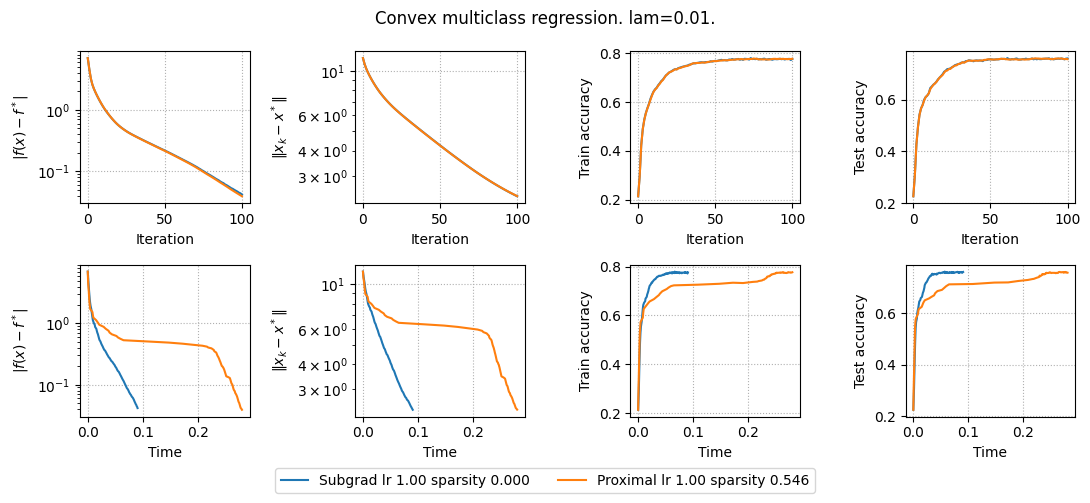

In [20]:
params = {
    "lam": 1e-2,
    "methods": [
        {
            "method": "Subgrad",
            "learning_rate": 1,
            "iterations": 100,
            
        },
        {
            "method": "Proximal",
            "learning_rate": 1,
            "iterations": 100,
            
        }
    ]
}

results, params = run_experiments(params)
plot_results(results, params)

Optimal accuracy 0.7827260494232178


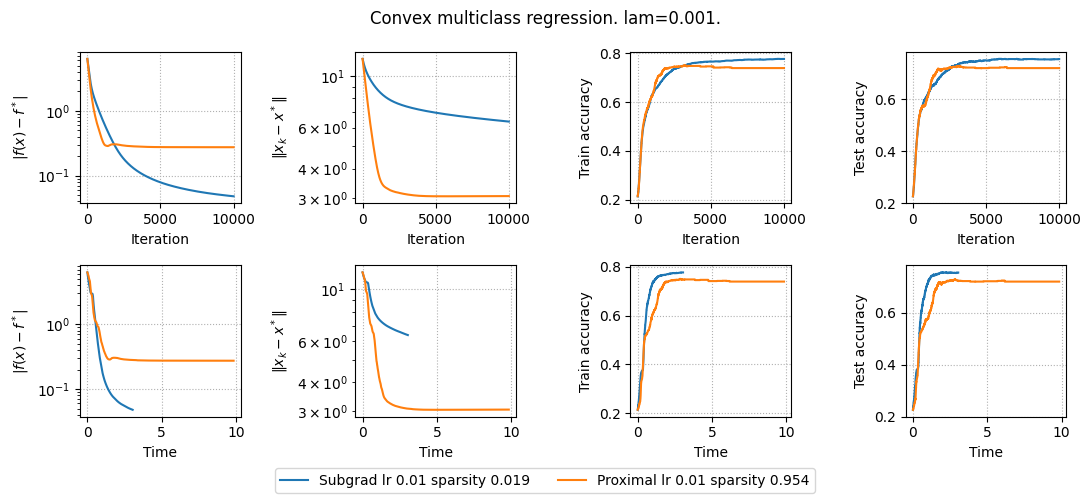

In [25]:
params = {
    "lam": 1e-3,
    "methods": [
        {
            "method": "Subgrad",
            "learning_rate": 1e-2,
            "iterations": 10000,
            
        },
        {
            "method": "Proximal",
            "learning_rate": 1e-2,
            "iterations": 10000,
            
        }
    ]
}

results, params = run_experiments(params)
plot_results(results, params)

Optimal accuracy 0.7371794581413269


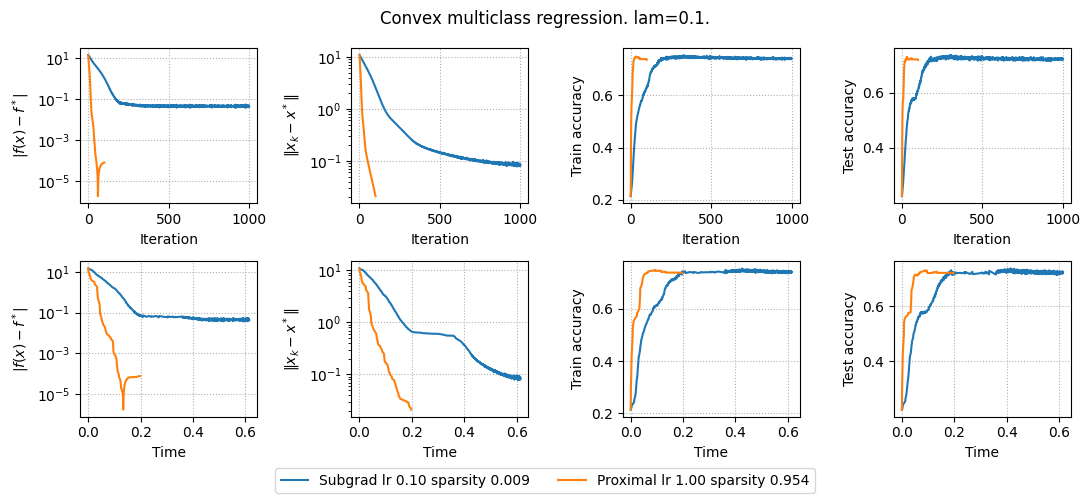

In [23]:
params = {
    "lam": 1e-1,
    "methods": [
        {
            "method": "Subgrad",
            "learning_rate": 1e-1,
            "iterations": 1000,
        },
        {
            "method": "Proximal",
            "learning_rate": 1,
            "iterations": 100,
        },
    ]
}

results, params = run_experiments(params)
plot_results(results, params)

Optimal accuracy 0.4180161952972412


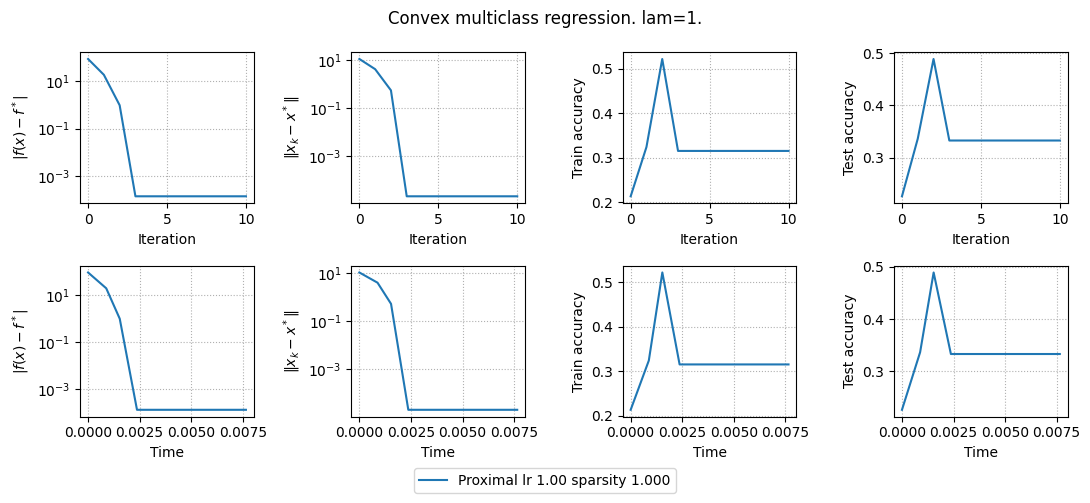

In [24]:
params = {
    "lam": 1,
    "methods": [
        {
            "method": "Proximal",
            "learning_rate": 1,
            "iterations": 10,
        },
    ]
}

results, params = run_experiments(params)
plot_results(results, params)

### Newton and quasinewton methods

#### 1. 😱 Newton convergence issue (10 points)

Consider the following function:
$$
f(x,y) = \dfrac{x^4}{4} - x^2 + 2x + (y-1)^2
$$
And the starting point is $x_0 = (0,2)^\top$. How does Newton’s method behave when started from this point? How can this be explained? How does the gradient descent with fixed step $\alpha = 0.01$ and the steepest descent method behave under the same conditions? (It is not necessary to show numerical simulations in this problem).

Сделаем один шаг метода Ньютона:

$$\nabla f(x, y) = [x^3-2x+2, 2(y-1)]^\top$$

$$\nabla^2 f(x, y) = \left(\begin{matrix}
3x^2-2 & 0 \\
0 & 2
\end{matrix}\right)$$

$$x_1 = x_0 - \nabla^2f(x)^{-1}\nabla f(x) = [0, 2] - \left(\begin{matrix}
-0.5 & 0 \\
0 & 0.5
\end{matrix}\right) [2, 2] = [1, 1]$$

Дальше продолжать смысла не вижу. Можно заметить, что гессиан в начальной точке неположительно определён, а значит ни про какую сходимость говорить нельзя.

Можно приравнять градиент к нулю и найти глобальный минимум $x^* = [-1.7693, 1]$

Теперь запустим градиентный спуск с шагом $\alpha=0.01$

In [78]:
def f(x):
    return x[0] ** 4 / 4 - x[0] ** 2 +2 * x[0] + (x[1] - 1) ** 2

def grad_f(x, y):
    return np.array([x **3 -2*x + 2, 2 * (y - 1)])

x0 = np.array([0., 2.])
x = x0.copy()
for i in range(1000):
    alpha = 0.01
    x -= alpha * grad_f(x[0], x[1])
print(x)

[-1.76929235  1.        ]


А вот градиентный спуск смог спуститься в минимум. Теперь посмотрим на найскорейший спуск.

In [80]:
from scipy.optimize import minimize_scalar

def backtracking_line_search(x, grad, func):
    def objective(t):
        return func(x - t * grad(x[0], x[1]))

    res = minimize_scalar(objective, method='golden')
    return res.x

x0 = np.array([0., 2.])
x = x0.copy()
for i in range(1000):
    alpha = backtracking_line_search(x, grad_f, f)
    x -= alpha * grad_f(x[0], x[1])
print(x)

[-1.76929237  1.        ]


Ну и тут тоже всё хорошо.

#### 2. Hessian-Free Newton method (20 points)

In this exercise, we’ll explore the optimization of a binary logistic regression problem using various methods. Don’t worry about the size of the problem description, first 5 bullets out of 7 could be done pretty quickly. In this problem you should start with this colab notebook

In [65]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
import jax
from jax import numpy as jnp, grad
from scipy.optimize import minimize_scalar
import jax.numpy as jnp
from jax import grad, jit, hessian
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import time
from ucimlrepo import fetch_ucirepo
from sklearn.preprocessing import StandardScaler
from scipy.optimize import minimize_scalar
import sklearn.datasets as skldata

# Set a random seed for reproducibility
np.random.seed(228)
jax.random.PRNGKey(228)

@jit
def logistic_loss(w, X, y, mu=1):
    m, n = X.shape
    return jnp.sum(jnp.logaddexp(0, -y * (X @ w))) / m + mu / 2 * jnp.sum(w**2)

def generate_problem(m=1000, n=300, mu=1):
    X, y = skldata.make_classification(n_classes=2, n_features=n, n_samples=m, n_informative=n//2, random_state=0)
    X = jnp.array(X)
    y = jnp.array(y)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

    return X_train, y_train, X_test, y_test

def compute_optimal(X, y, mu):
    w = cp.Variable(X.shape[1])
    objective = cp.Minimize(cp.sum(cp.logistic(cp.multiply(-y, X @ w))) / len(y) + mu / 2 * cp.norm(w, 2)**2)
    problem = cp.Problem(objective)
    problem.solve()
    return w.value, problem.value

@jit
def compute_accuracy(w, X, y):
    # Compute predicted probabilities using the logistic (sigmoid) function
    preds_probs = jax.nn.sigmoid(X @ w)
    # Convert probabilities to class predictions: -1 if p < 0.5, else 1
    preds = jnp.where(preds_probs < 0.5, 0, 1)
    # Calculate accuracy as the average of correct predictions
    accuracy = jnp.mean(preds == y)
    return accuracy



# @jit
def compute_metrics(trajectory, x_star, f_star, times, X_train, y_train, X_test, y_test, mu):
    f = lambda w: logistic_loss(w, X_train, y_train, mu)
    metrics = {
        "f_gap": [jnp.abs(f(x) - f_star) for x in trajectory],
        "x_gap": [jnp.linalg.norm(x - x_star) for x in trajectory],
        "time": times,
        "train_acc": [compute_accuracy(x, X_train, y_train) for x in trajectory],
        "test_acc": [compute_accuracy(x, X_test, y_test) for x in trajectory],
    }
    return metrics

def gradient_descent(w_0, X, y, learning_rate=0.01, num_iters=100, mu=0):
    trajectory = [w_0]
    times = [0]
    w = w_0
    f = lambda w: logistic_loss(w, X, y, mu)
    iter_start = time.time()
    for i in range(num_iters):
        grad_val = grad(f)(w)
        if learning_rate == "linesearch":
            # Simple line search implementation
            phi = lambda alpha: f(w - alpha*grad_val)
            result = minimize_scalar(fun=phi, 
                                     bounds=(1e-3, 2e2)
                              )
            step_size = result.x
        else:
            step_size = learning_rate
        w -= step_size * grad_val
        iter_time = time.time()
        trajectory.append(w)
        times.append(iter_time - iter_start)
    return trajectory, times

def newton_method(w_0, X, y, damping=2e-1, num_iters=100, mu=0):
    trajectory = [w_0]
    times = [0]
    w = w_0
    f = lambda w: logistic_loss(w, X, y, mu)

    iter_start = time.time()
    for i in range(num_iters):
        gradient = grad(f)(w)
        hessian_matrix = hessian(f)(w)

        # Reshape the Hessian matrix
        hessian_reshaped = hessian_matrix.reshape(w.size, w.size)

        # Calculate the Newton step using the reshaped Hessian
        newton_step = jnp.linalg.solve(hessian_reshaped, gradient.ravel()).reshape(w.shape)
        
        # Update parameters using a damping factor
        w -= damping * newton_step
        
        # Store trajectory and time
        iter_time = time.time()
        trajectory.append(w)
        times.append(iter_time - iter_start)

    return trajectory, times

def newton_method_cg(w_0, X, y, damping=2e-1, num_iters=100, mu=0):
    trajectory = [w_0]
    times = [0]
    w = w_0
    f = lambda w: logistic_loss(w, X, y, mu)

    iter_start = time.time()
    for i in range(num_iters):
        gradient = grad(f)(w)
        hessian_matrix = hessian(f)(w)

        # Reshape the Hessian matrix
        hessian_reshaped = hessian_matrix.reshape(w.size, w.size)

        # Calculate the Newton step using the reshaped Hessian
        ### YOUR CODE HERE
        newton_step = jax.scipy.sparse.linalg.cg(hessian_reshaped, gradient)
        
        # Update parameters using a damping factor
        w -= damping * newton_step[0]
        
        # Store trajectory and time
        iter_time = time.time()
        trajectory.append(w)
        times.append(iter_time - iter_start)

    return trajectory, times

def newton_method_hfn(w_0, X, y, damping=2e-1, num_iters=100, mu=0):
    trajectory = [w_0]
    times = [0]
    w = w_0
    f = lambda w: logistic_loss(w, X, y, mu)

    iter_start = time.time()
    for i in range(num_iters):
        gradient = grad(f)(w)
        hessian_matrix = hessian(f)(w)

        # Reshape the Hessian matrix
        hessian_reshaped = hessian_matrix.reshape(w.size, w.size)

        # Calculate the Newton step using the reshaped Hessian
        def hvp(v):
            return (grad(f)(w + 1e-5 * v) - gradient)/1e-5

        newton_step = jax.scipy.sparse.linalg.cg(hvp, gradient, atol=1e-5)[0]
        
        # Update parameters using a damping factor
        w -= damping * newton_step
        
        # Store trajectory and time
        iter_time = time.time()
        trajectory.append(w)
        times.append(iter_time - iter_start)

    return trajectory, times

def run_experiments(params):
    mu = params["mu"]
    m, n = params["m"], params["n"]
    methods = params["methods"]
    results = {}

    X_train, y_train, X_test, y_test = generate_problem(m, n, mu)
    n_features = X_train.shape[1]  # Number of features
    params["n_features"] = n_features
    
    x_0 = jax.random.normal(jax.random.PRNGKey(0), (n_features, ))
    x_star, f_star = compute_optimal(X_train, y_train, mu)

    for method in methods:
        if method["method"] == "GD":
            learning_rate = method["learning_rate"]
            iterations = method["iterations"]
            trajectory, times = gradient_descent(x_0, X_train, y_train, learning_rate, iterations, mu)
            label = method["method"] + " " + str(learning_rate)
            results[label] = compute_metrics(trajectory, x_star, f_star, times, X_train, y_train, X_test, y_test, mu)
        elif method["method"] == "Newton":
            if "learning_rate" not in method.keys():
                learning_rate = 1
            else:
                learning_rate = method["learning_rate"]
            iterations = method["iterations"]
            trajectory, times = newton_method(x_0, X_train, y_train, learning_rate, iterations, mu)
            label = method["method"] + " " + str(learning_rate)
            results[label] = compute_metrics(trajectory, x_star, f_star, times, X_train, y_train, X_test, y_test, mu)
        elif method["method"] == "Newton-CG":
            if "learning_rate" not in method.keys():
                learning_rate = 1
            else:
                learning_rate = method["learning_rate"]
            iterations = method["iterations"]
            trajectory, times = newton_method_cg(x_0, X_train, y_train, learning_rate, iterations, mu)
            label = method["method"] + " " + str(learning_rate)
            results[label] = compute_metrics(trajectory, x_star, f_star, times, X_train, y_train, X_test, y_test, mu)
        elif method["method"] == "Newton-HFN":
            if "learning_rate" not in method.keys():
                learning_rate = 1
            else:
                learning_rate = method["learning_rate"]
            iterations = method["iterations"]
            trajectory, times = newton_method_hfn(x_0, X_train, y_train, learning_rate, iterations, mu)
            label = method["method"] + " " + str(learning_rate)
            results[label] = compute_metrics(trajectory, x_star, f_star, times, X_train, y_train, X_test, y_test, mu)

    return results, params

def plot_results(results, params):
    plt.figure(figsize=(11, 5))
    mu = params["mu"]
    
    if mu > 1e-2:
        plt.suptitle(f"Strongly convex binary logistic regression. mu={mu}.")
    else:
        plt.suptitle(f"Convex binary logistic regression. mu={mu}.")

    plt.subplot(2, 4, 1)
    for method, metrics in results.items():
        plt.plot(metrics['f_gap'])
    plt.xlabel('Iteration')
    plt.ylabel(r'$|f(x) -f^*|$')
    plt.yscale('log')
    plt.grid(linestyle=":")

    plt.subplot(2, 4, 2)
    for method, metrics in results.items():
        plt.plot(metrics['x_gap'], label=method)
    plt.xlabel('Iteration')
    plt.ylabel('$\|x_k - x^*\|$')
    plt.yscale('log')
    plt.grid(linestyle=":")

    plt.subplot(2, 4, 3)
    for method, metrics in results.items():
        plt.plot(metrics["train_acc"])
    plt.xlabel('Iteration')
    plt.ylabel('Train accuracy')
    # plt.yscale('log')
    plt.grid(linestyle=":")

    plt.subplot(2, 4, 4)
    for method, metrics in results.items():
        plt.plot(metrics["test_acc"])
    plt.xlabel('Iteration')
    plt.ylabel('Test accuracy')
    # plt.yscale('log')
    plt.grid(linestyle=":")

    plt.subplot(2, 4, 5)
    for method, metrics in results.items():
        plt.plot(metrics["time"], metrics['f_gap'])
    plt.xlabel('Time')
    plt.ylabel(r'$|f(x) -f^*|$')
    plt.yscale('log')
    plt.grid(linestyle=":")

    plt.subplot(2, 4, 6)
    for method, metrics in results.items():
        plt.plot(metrics["time"], metrics['x_gap'])
    plt.xlabel('Time')
    plt.ylabel('$\|x_k - x^*\|$')
    plt.yscale('log')
    plt.grid(linestyle=":")

    plt.subplot(2, 4, 7)
    for method, metrics in results.items():
        plt.plot(metrics["time"], metrics["train_acc"])
    plt.xlabel('Time')
    plt.ylabel('Train accuracy')
    # plt.yscale('log')
    plt.grid(linestyle=":")

    plt.subplot(2, 4, 8)
    for method, metrics in results.items():
        plt.plot(metrics["time"], metrics["test_acc"])
    plt.xlabel('Time')
    plt.ylabel('Test accuracy')
    # plt.yscale('log')
    plt.grid(linestyle=":")

    # Place the legend below the plots
    plt.figlegend(loc='lower center', ncol=5, bbox_to_anchor=(0.5, -0.00))
    # Adjust layout to make space for the legend below
    filename = ""
    for method, metrics in results.items():
        filename += method
    filename += f"_{mu}.pdf"
    plt.tight_layout(rect=[0, 0.05, 1, 1])
    plt.savefig(filename)
    plt.show()

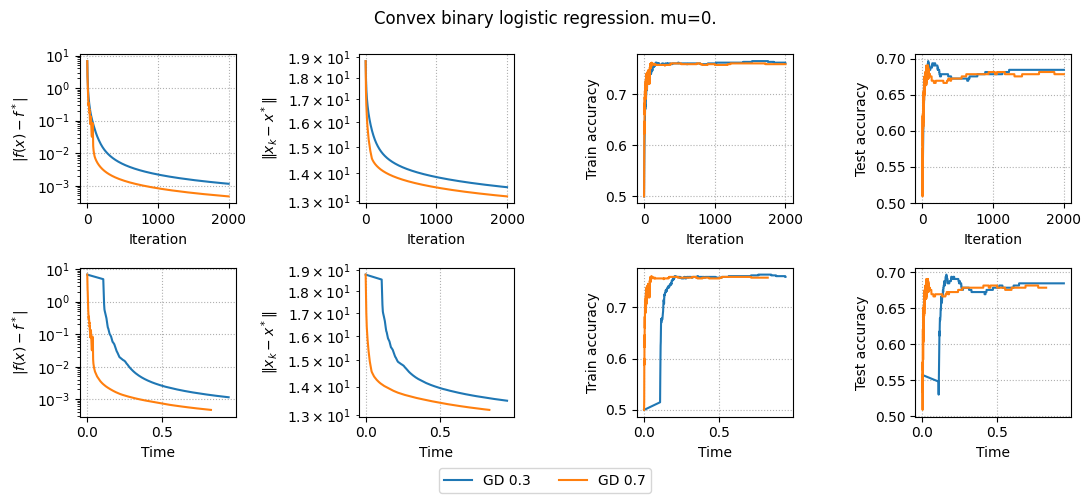

In [66]:
params = {
    "mu": 0,
    "m": 1000,
    "n": 100,
    "methods": [
        {
            "method": "GD",
            "learning_rate": 3e-1,
            "iterations": 2000,
        },
        {
            "method": "GD",
            "learning_rate": 7e-1,
            "iterations": 2000,
        },
    ]
}

results, params = run_experiments(params)
plot_results(results, params)

Сублинейная сходимость

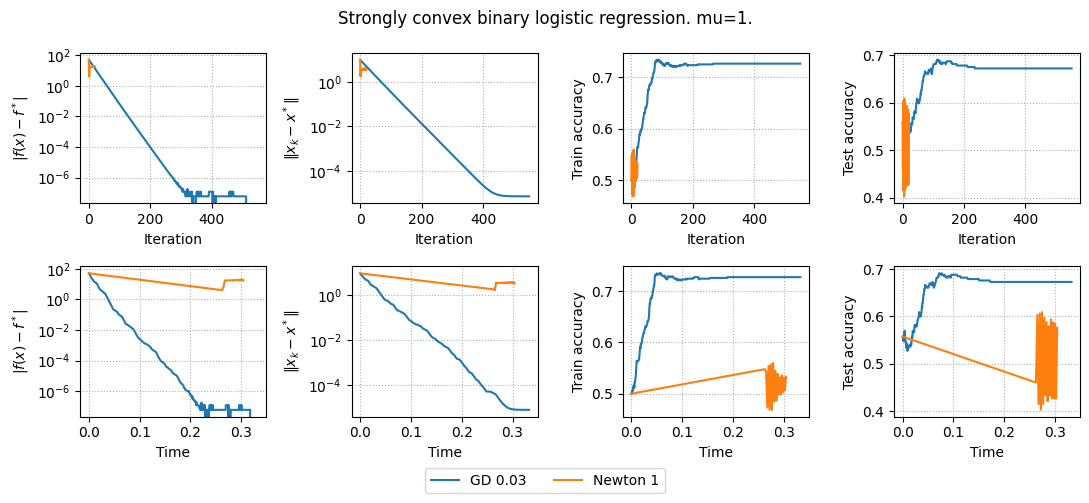

In [67]:
params = {
    "mu": 1,
    "m": 1000,
    "n": 100,
    "methods": [
        {
            "method": "GD",
            "learning_rate": 3e-2,
            "iterations": 550,
        },
        {
            "method": "Newton",
            "iterations": 20,
        },
    ]
}

results, params = run_experiments(params)
plot_results(results, params)

Ньютон не сходится, GD сходится линейно

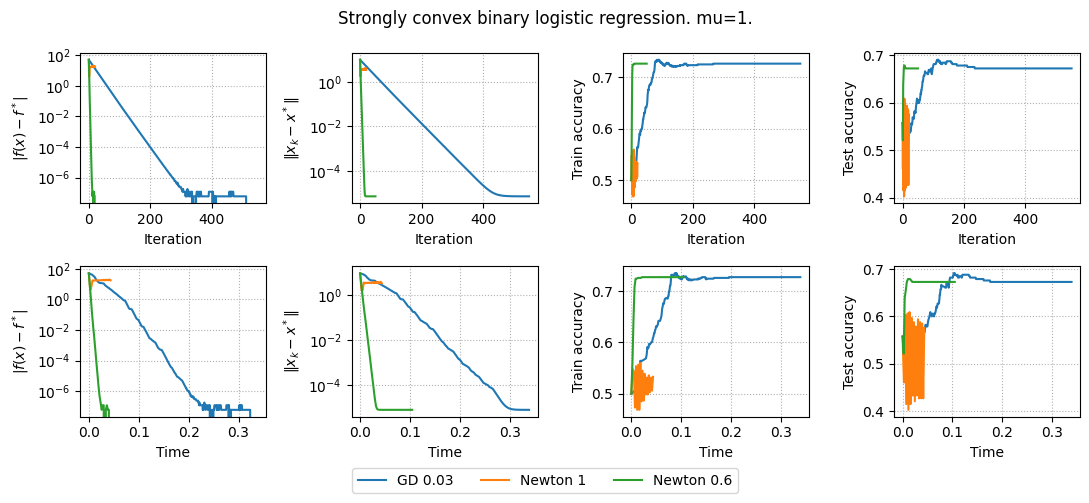

In [72]:
params = {
    "mu": 1,
    "m": 1000,
    "n": 100,
    "methods": [
        {
            "method": "GD",
            "learning_rate": 3e-2,
            "iterations": 550,
        },
        {
            "method": "Newton",
            "iterations": 20,
        },
        {
            "method": "Newton",
            "learning_rate": 0.6,
            "iterations": 50,
        },
    ]
}

results, params = run_experiments(params)
plot_results(results, params)

Вроде это максимум

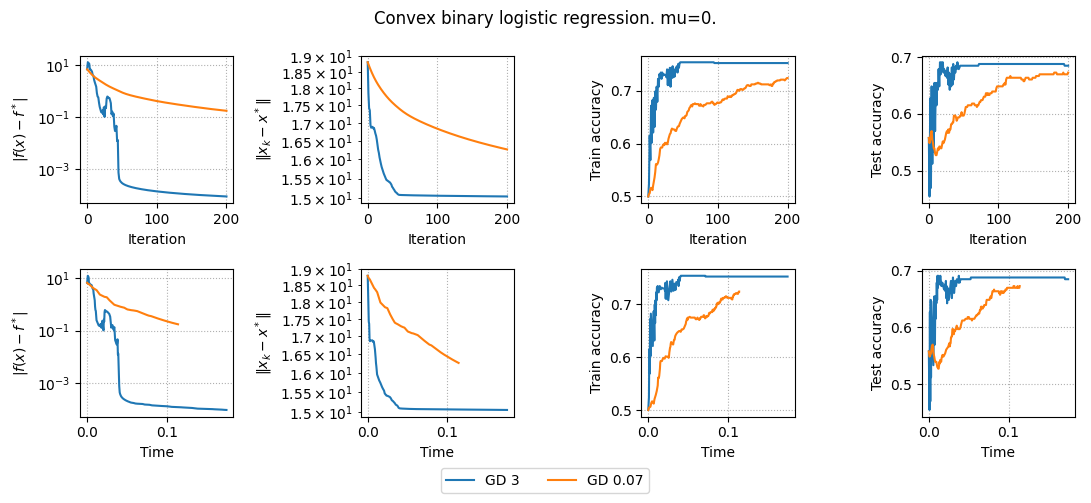

In [104]:
params = {
    "mu": 0,
    "m": 1000,
    "n": 100,
    "methods": [
        {
            "method": "GD",
            "learning_rate": 3,
            "iterations": 200,
        },
        {
            "method": "GD",
            "learning_rate": 7e-2,
            "iterations": 200,
        },
    ]
}

results, params = run_experiments(params)
plot_results(results, params)

Кажется, что максимальный lr равен 3. Сходимость линейная до какого-то момента. Чтобы добиться tight primal gap стоит брать меньший лернинг рейт и большее число итераций.

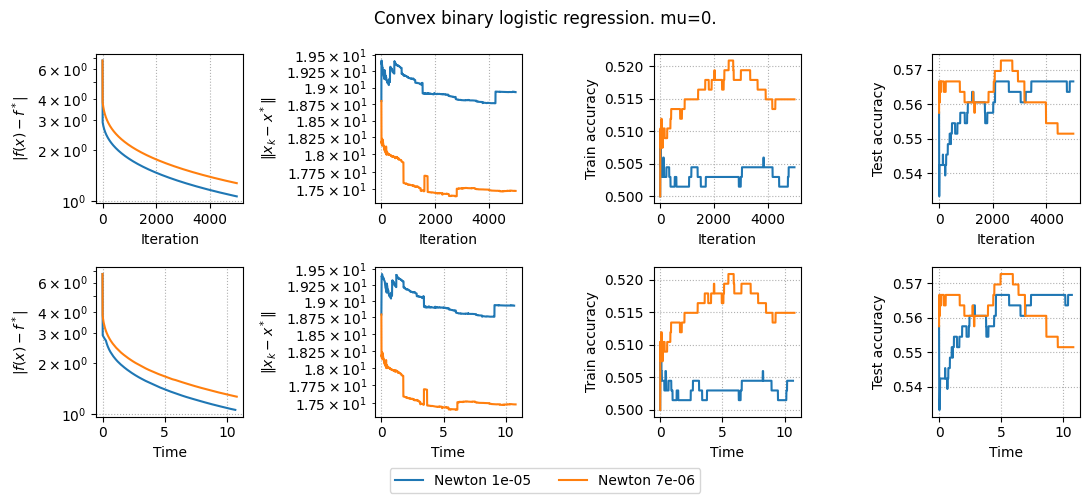

In [109]:
params = {
    "mu": 0,
    "m": 1000,
    "n": 100,
    "methods": [
        {
            "method": "Newton",
            "learning_rate": 1e-5,
            "iterations": 5000,
        },
        {
            "method": "Newton",
            "learning_rate": 7e-6,
            "iterations": 5000,
        },
    ]
}

results, params = run_experiments(params)
plot_results(results, params)

Если взять достаточно маленькие значения lr, то вроде есть нечто похожее на сходимость, правда по итогу очень далеко от оптимума.

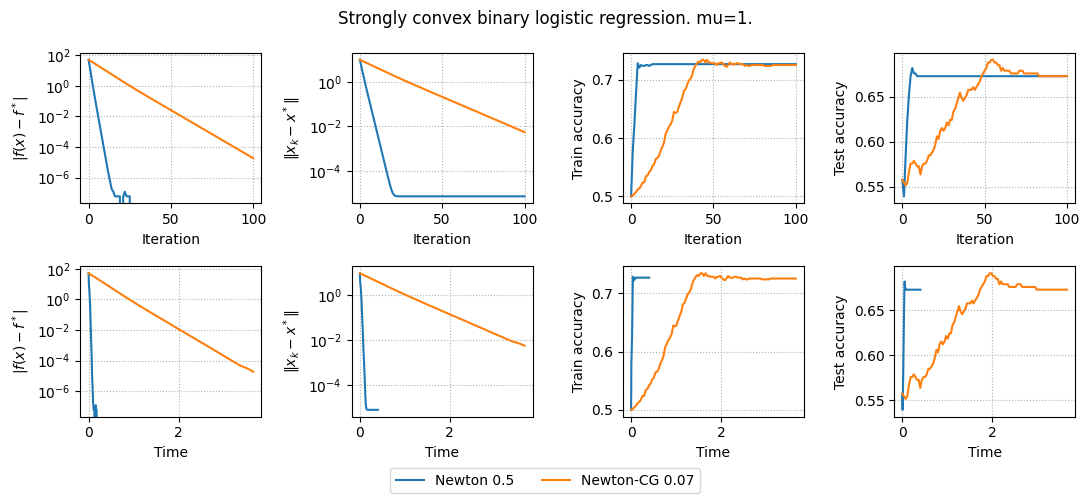

In [118]:
params = {
    "mu": 1,
    "m": 1000,
    "n": 100,
    "methods": [
        {
            "method": "Newton",
            "learning_rate": 0.5,
            "iterations": 100,
        },
        {
            "method": "Newton-CG",
            "learning_rate": 7e-2,
            "iterations": 100,
        },
    ]
}

results, params = run_experiments(params)
plot_results(results, params)

Сходимость Ньютона тут похожа на суперлинейную(что вроде логично), CG линейная, объяснений толковых нет, разве что слу решается приближённо.

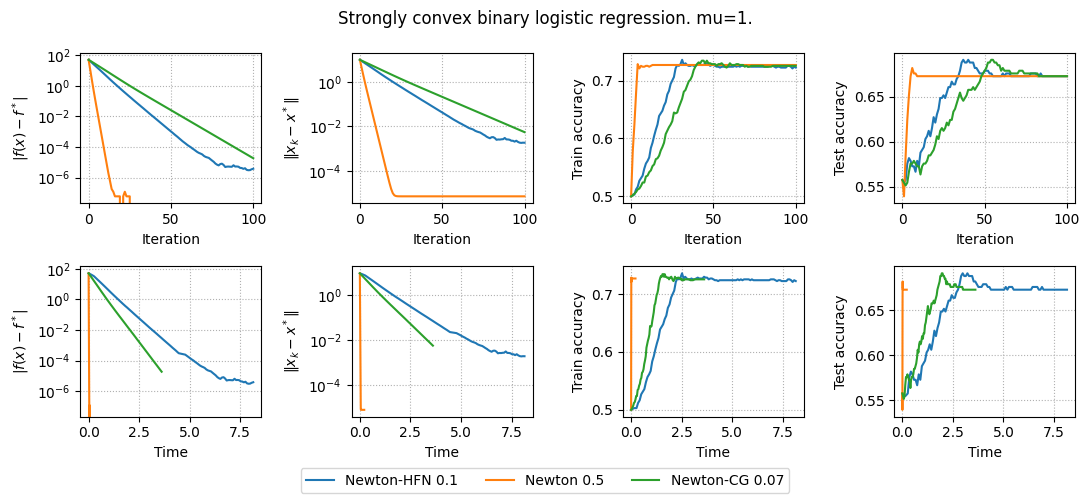

In [123]:
params = {
    "mu": 1,
    "m": 1000,
    "n": 100,
    "methods": [
        {
            "method": "Newton-HFN",
            "learning_rate": 0.1,
            "iterations": 100,
        },
        {
            "method": "Newton",
            "learning_rate": 0.5,
            "iterations": 100,
        },
        {
            "method": "Newton-CG",
            "learning_rate": 7e-2,
            "iterations": 100,
        },
    ]
}

results, params = run_experiments(params)
plot_results(results, params)

Ньютон сходится суперлинейно, остальные линейно. причина аналогична прошлому пункту.

### Stochastic gradient methods

#### Binary logistic regression

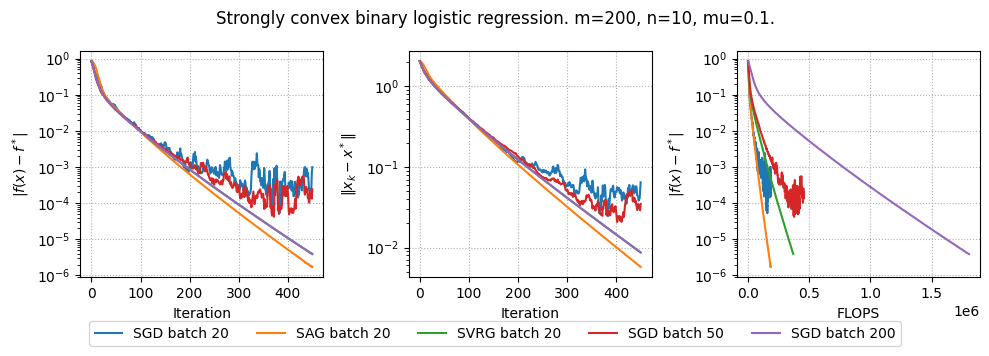

In [52]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
import jax
from jax import numpy as jnp, grad
import sklearn.datasets as skldata

# Set a random seed for reproducibility
np.random.seed(228)
jax.random.PRNGKey(228)

def logistic_loss(w, X, y, mu=1):
    m, n = X.shape
    return jnp.sum(jnp.logaddexp(0, -y * (X @ w))) / m + mu / 2 * jnp.sum(w**2)

def generate_problem(m=1000, n=300, mu=1):
    X, y = skldata.make_classification(n_classes=2, n_features=n, n_samples=m, n_informative=n//2, random_state=0)
    X = jnp.array(X)
    y = jnp.array(y)
    return X, y

def compute_optimal(X, y, mu):
    w = cp.Variable(X.shape[1])
    objective = cp.Minimize(cp.sum(cp.logistic(cp.multiply(-y, X @ w))) / len(y) + mu / 2 * cp.norm(w, 2)**2)
    problem = cp.Problem(objective)
    problem.solve()
    return w.value, problem.value

def stochastic_gradient_descent(X, y, x_0, learning_rate, iterations, batch_size=1, mu=0):
    m, n = X.shape
    x = x_0
    flops = 0
    trajectory = [x]
    flops_trajectory = [flops]
    for _ in range(iterations):
        indices = np.random.choice(m, batch_size, replace=False)
        X_batch, y_batch = X[indices], y[indices]
        f_batch = lambda w: logistic_loss(w, X=X_batch, y=y_batch, mu=mu)
        grad_f_batch = grad(f_batch)
        x -= learning_rate * grad_f_batch(x)
        trajectory.append(x)
        flops += (2 * n * batch_size + n) 
        flops_trajectory.append(flops)
    return trajectory, flops_trajectory

def sag(X, y, x_0, learning_rate, iterations, batch_size=1, mu=0):
    m, n = X.shape
    x = x_0
    gradients = jnp.zeros((m, n))
    average_grad = jnp.zeros(n)
    flops = 0
    trajectory = [x]
    flops_trajectory = [flops]
    for _ in range(iterations):
        indices = np.random.choice(m, batch_size, replace=False)
        for idx in indices:
            f_i = lambda w: logistic_loss(w, X[idx:idx+1], y[idx:idx+1], mu=mu)
            grad_f_i = grad(f_i)
            new_grad = grad_f_i(x)
            average_grad += (new_grad - gradients[idx]) / m
            gradients = gradients.at[idx].set(new_grad)
        x -= learning_rate * average_grad
        trajectory.append(x)
        flops += (2 * n * batch_size + n) 
        flops_trajectory.append(flops)
    return trajectory, flops_trajectory

def svrg(X, y, x_0, learning_rate, epoch_length, iterations, batch_size=1, mu=0):
    m, n = X.shape
    x = x_0
    flops = 0
    trajectory = [x]
    flops_trajectory = [flops]
    for _ in range(iterations // epoch_length):
        full_grad = grad(lambda w: logistic_loss(w, X, y, mu))(x)
        x_tilde = x
        for _ in range(epoch_length):
            indices = np.random.choice(m, batch_size, replace=False)
            X_batch, y_batch = X[indices], y[indices]
            grad_f_batch = grad(lambda w: logistic_loss(w, X_batch, y_batch, mu))
            grad_f_batch_tilde = grad(lambda w: logistic_loss(w, X_batch, y_batch, mu))(x_tilde)
            x -= learning_rate * (grad_f_batch(x) - grad_f_batch_tilde + full_grad)
            trajectory.append(x)
            flops += (4 * n * batch_size + 2 * n) 
            flops_trajectory.append(flops)
    return trajectory, flops_trajectory

def compute_metrics(trajectory, x_star, f_star, f, flops_trajectory):
    metrics = {
        "f_gap": [jnp.abs(f(x) - f_star) for x in trajectory],
        "x_gap": [jnp.linalg.norm(x - x_star) for x in trajectory],
        "flops": flops_trajectory,
    }
    return metrics

def run_experiments(params):
    m, n, mu = params["m"], params["n"], params["mu"]
    methods = params["methods"]
    results = {}

    X, y = generate_problem(m, n, mu)
    x_0 = jax.random.normal(jax.random.PRNGKey(0), (n,))
    # Compute the optimal solution using CVXPY
    x_star, f_star = compute_optimal(X, y, mu)

    for method_params in methods:
        method = method_params["method"]
        if method == "SGD":
            trajectory, flops_trajectory = stochastic_gradient_descent(
                X, y, x_0, method_params["learning_rate"], method_params["iterations"], method_params["batch_size"], mu
            )
        elif method == "SAG":
            trajectory, flops_trajectory = sag(
                X, y, x_0, method_params["learning_rate"], method_params["iterations"], method_params["batch_size"], mu
            )
        elif method == "SVRG":
            trajectory, flops_trajectory = svrg(
                X, y, x_0, method_params["learning_rate"], method_params["epoch_length"], method_params["iterations"], method_params["batch_size"], mu
            )
        label = f"{method} batch {method_params['batch_size']}"
        results[label] = compute_metrics(trajectory, x_star, f_star, f=lambda x: logistic_loss(x, X, y, mu), flops_trajectory=flops_trajectory)
    return results

def plot_results(results, params):
    plt.figure(figsize=(10, 3.5))
    mu = params["mu"]
    m = params["m"]
    n = params["n"]
    
    if mu > 1e-2:
        plt.suptitle(f"Strongly convex binary logistic regression. m={m}, n={n}, mu={mu}.")
    else:
        plt.suptitle(f"Convex binary logistic regression. m={m}, n={n}, mu={mu}.")

    plt.subplot(1, 3, 1)
    for method, metrics in results.items():
        plt.plot(metrics['f_gap'])
    plt.xlabel('Iteration')
    plt.ylabel(r'$|f(x) -f^*|$')
    plt.yscale('log')
    plt.grid(linestyle=":")

    plt.subplot(1, 3, 2)
    for method, metrics in results.items():
        plt.plot(metrics['x_gap'], label=method)
    plt.xlabel('Iteration')
    plt.ylabel('$\|x_k - x^*\|$')
    plt.yscale('log')
    plt.grid(linestyle=":")

    plt.subplot(1, 3, 3)
    for method, metrics in results.items():
        plt.plot(metrics["flops"], metrics['f_gap'])
    plt.xlabel('FLOPS')
    plt.ylabel(r'$|f(x) -f^*|$')
    plt.yscale('log')
    plt.grid(linestyle=":")

    # Place the legend below the plots
    plt.figlegend(loc='lower center', ncol=5, bbox_to_anchor=(0.5, -0.00))
    # Adjust layout to make space for the legend below
    plt.tight_layout(rect=[0, 0.05, 1, 1])
    plt.savefig(f"sgd_{mu}_{m}_{n}.pdf")
    plt.show()

params = {
    "mu": 1e-1,
    "m": 200,
    "n": 10,
    "methods": [
        {
            "method": "SGD",
            "learning_rate": 1e-1,
            "batch_size": 20,
            "iterations": 450,
        },
        {
            "method": "SAG",
            "learning_rate": 1e-1,
            "batch_size": 20,
            "iterations": 450,
        },
        {
            "method": "SVRG",
            "learning_rate": 1e-1,
            "epoch_length": 3,
            "batch_size": 20,
            "iterations": 450,
        },
        {
            "method": "SGD",
            "learning_rate": 1e-1,
            "batch_size": 50,
            "iterations": 450,
        },
        {
            "method": "SGD",
            "learning_rate": 1e-1,
            "batch_size": 200,
            "iterations": 450,
        },
    ]
}

results = run_experiments(params)
plot_results(results, params)

#### Linear least squares

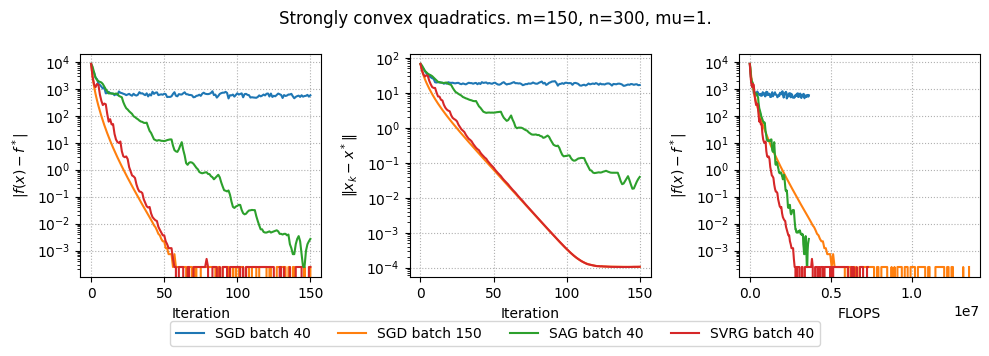

In [51]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
import jax
from jax import numpy as jnp, grad
import sklearn.datasets as skldata

# Set a random seed for reproducibility
np.random.seed(228)
jax.random.PRNGKey(228)

def least_squares_loss(w, X, y, mu=1):
    m, n = X.shape
    residuals = X @ w - y
    return jnp.sum(residuals ** 2) / (2 * m) + mu / 2 * jnp.sum(w ** 2)

def generate_problem(m=1000, n=300, mu=1):
    X, y = skldata.make_regression(n_features=n, n_samples=m, noise=1e-3, random_state=0)
    X = jnp.array(X)
    y = jnp.array(y)
    return X, y

def compute_optimal(X, y, mu):
    w = cp.Variable(X.shape[1])
    residuals = X @ w - y
    objective = cp.Minimize(cp.sum_squares(residuals) / (2 * len(y)) + mu / 2 * cp.norm(w, 2)**2)
    problem = cp.Problem(objective)
    problem.solve()
    return w.value, problem.value

def stochastic_gradient_descent(X, y, x_0, learning_rate, iterations, batch_size=1, mu=1):
    m, n = X.shape
    x = x_0
    flops = 0
    trajectory = [x]
    flops_trajectory = [flops]
    for _ in range(iterations):
        indices = np.random.choice(m, batch_size, replace=False)
        X_batch, y_batch = X[indices], y[indices]
        f_batch = lambda w: least_squares_loss(w, X=X_batch, y=y_batch, mu=mu)
        grad_f_batch = grad(f_batch)
        x -= learning_rate * grad_f_batch(x)
        trajectory.append(x)
        flops += (2 * n * batch_size + n) 
        flops_trajectory.append(flops)
    return trajectory, flops_trajectory

def sag(X, y, x_0, learning_rate, iterations, batch_size=1, mu=1):
    m, n = X.shape
    x = x_0
    gradients = jnp.zeros((m, n))
    average_grad = jnp.zeros(n)
    flops = 0
    trajectory = [x]
    flops_trajectory = [flops]
    for _ in range(iterations):
        indices = np.random.choice(m, batch_size, replace=False)
        for idx in indices:
            f_i = lambda w: least_squares_loss(w, X[idx:idx+1], y[idx:idx+1], mu=mu)
            grad_f_i = grad(f_i)
            new_grad = grad_f_i(x)
            average_grad += (new_grad - gradients[idx]) / m
            gradients = gradients.at[idx].set(new_grad)
        x -= learning_rate * average_grad
        trajectory.append(x)
        flops += (2 * n * batch_size + n) 
        flops_trajectory.append(flops)
    return trajectory, flops_trajectory

def svrg(X, y, x_0, learning_rate, epoch_length, iterations, batch_size=1, mu=1):
    m, n = X.shape
    x = x_0
    flops = 0
    trajectory = [x]
    flops_trajectory = [flops]
    for _ in range(iterations // epoch_length):
        full_grad = grad(lambda w: least_squares_loss(w, X, y, mu))(x)
        x_tilde = x
        for _ in range(epoch_length):
            indices = np.random.choice(m, batch_size, replace=False)
            X_batch, y_batch = X[indices], y[indices]
            grad_f_batch = grad(lambda w: least_squares_loss(w, X_batch, y_batch, mu))
            grad_f_batch_tilde = grad(lambda w: least_squares_loss(w, X_batch, y_batch, mu))(x_tilde)
            x -= learning_rate * (grad_f_batch(x) - grad_f_batch_tilde + full_grad)
            trajectory.append(x)
            flops += (4 * n * batch_size + 2 * n) 
            flops_trajectory.append(flops)
    return trajectory, flops_trajectory

def compute_metrics(trajectory, x_star, f_star, f, flops_trajectory):
    metrics = {
        "f_gap": [jnp.abs(f(x) - f_star) for x in trajectory],
        "x_gap": [jnp.linalg.norm(x - x_star) for x in trajectory],
        "flops": flops_trajectory,
    }
    return metrics

def run_experiments(params):
    m, n, mu = params["m"], params["n"], params["mu"]
    methods = params["methods"]
    results = {}

    X, y = generate_problem(m, n, mu)
    x_0 = jax.random.normal(jax.random.PRNGKey(0), (n,))
    # Compute the optimal solution using CVXPY
    x_star, f_star = compute_optimal(X, y, mu)

    for method_params in methods:
        method = method_params["method"]
        if method == "SGD":
            trajectory, flops_trajectory = stochastic_gradient_descent(
                X, y, x_0, method_params["learning_rate"], method_params["iterations"], method_params["batch_size"], mu
            )
        elif method == "SAG":
            trajectory, flops_trajectory = sag(
                X, y, x_0, method_params["learning_rate"], method_params["iterations"], method_params["batch_size"], mu
            )
        elif method == "SVRG":
            trajectory, flops_trajectory = svrg(
                X, y, x_0, method_params["learning_rate"], method_params["epoch_length"], method_params["iterations"], method_params["batch_size"], mu
            )
        label = f"{method} batch {method_params['batch_size']}"
        results[label] = compute_metrics(trajectory, x_star, f_star, f=lambda x: least_squares_loss(x, X, y, mu), flops_trajectory=flops_trajectory)
    return results

def plot_results(results, params):
    plt.figure(figsize=(10, 3.5))
    mu = params["mu"]
    m = params["m"]
    n = params["n"]
    
    if mu > 1e-2:
        plt.suptitle(f"Strongly convex quadratics. m={m}, n={n}, mu={mu}.")
    else:
        plt.suptitle(f"Convex quadratics. m={m}, n={n}, mu={mu}.")

    plt.subplot(1, 3, 1)
    for method, metrics in results.items():
        plt.plot(metrics['f_gap'])
    plt.xlabel('Iteration')
    plt.ylabel(r'$|f(x) -f^*|$')
    plt.yscale('log')
    plt.grid(linestyle=":")

    plt.subplot(1, 3, 2)
    for method, metrics in results.items():
        plt.plot(metrics['x_gap'], label=method)
    plt.xlabel('Iteration')
    plt.ylabel('$\|x_k - x^*\|$')
    plt.yscale('log')
    plt.grid(linestyle=":")

    plt.subplot(1, 3, 3)
    for method, metrics in results.items():
        plt.plot(metrics["flops"], metrics['f_gap'])
    plt.xlabel('FLOPS')
    plt.ylabel(r'$|f(x) -f^*|$')
    plt.yscale('log')
    plt.grid(linestyle=":")

    # Place the legend below the plots
    plt.figlegend(loc='lower center', ncol=5, bbox_to_anchor=(0.5, -0.00))
    # Adjust layout to make space for the legend below
    plt.tight_layout(rect=[0, 0.05, 1, 1])
    plt.savefig(f"sgd_{mu}_{m}_{n}.pdf")
    plt.show()

params = {
    "mu": 1,
    "m": 150,
    "n": 300,
    "methods": [
        {
            "method": "SGD",
            "learning_rate": 1e-1,
            "batch_size": 40,
            "iterations": 150,
        },
        {
            "method": "SGD",
            "learning_rate": 1e-1,
            "batch_size": 150,
            "iterations": 150,
        },
        {
            "method": "SAG",
            "learning_rate": 1e-1,
            "batch_size": 40,
            "iterations": 150,
        },
        {
            "method": "SVRG",
            "learning_rate": 1e-1,
            "epoch_length": 5,
            "batch_size": 40,
            "iterations": 150,
        },
    ]
}

results = run_experiments(params)
plot_results(results, params)

### Neural Network training

#### 1. Anomaly detection with neural network. [20 points]

In [26]:
import numpy as np
import pandas as pd
import jax
import jax.numpy as jnp
from flax import linen as nn
from flax.training import train_state
import optax
from matplotlib import pyplot as plt
from tqdm.auto import tqdm

In [27]:
import plotly.graph_objs as go
import pandas as pd

# Load the dataset
url = "https://raw.githubusercontent.com/numenta/NAB/master/data/realKnownCause/nyc_taxi.csv"
df = pd.read_csv(url, parse_dates=True, index_col="timestamp")

# Define the anomalies
anomalies = {
    "NYC Marathon": "2014-11-02 01:00",
    "Thanksgiving": "2014-11-27 16:30",
    "Christmas": "2014-12-25 16:30",
    "New Year's Day": "2015-01-01 01:00",
    "Snow Storm": "2015-01-27 13:30"
}

# Create the plot
fig = go.Figure()

# Add the main trace
fig.add_trace(go.Scatter(x=df.index, y=df['value'], mode='lines', name='Taxi Passengers'))

# Add anomaly points with unique markers
markers = ['circle', 'square', 'diamond', 'triangle-up', 'triangle-down']
for (label, date), marker in zip(anomalies.items(), markers):
    fig.add_trace(go.Scatter(
        x=[date],
        y=[df.loc[date]['value']],
        mode='markers+text',
        name=label,
        text=label,
        textposition="top center",
        marker=dict(symbol=marker, size=10, color='red')
    ))

# Update layout
fig.update_layout(
    title='New York City Taxi Passengers with Anomalies Highlighted',
    xaxis_title='Date',
    yaxis_title='Number of Passengers',
    legend_title='Legend',
    template='plotly_white'
)

# Show the figure
# Config for the plot
plotly_config = {
    'displaylogo': False,
    'toImageButtonOptions': {
        'format': 'svg', # one of png, svg, jpeg, webp
        'filename': 'fmin',
        'height': None,
        'width': None,
        'scale': 1 # Multiply title/legend/axis/canvas sizes by this factor
    },
    'modeBarButtonsToRemove': ['select2d', 'lasso2d'],
    'modeBarButtonsToAdd': [
                            'drawopenpath',
                            'eraseshape'
                            ]
}

# Show the figure with the specified config
fig.show(config=plotly_config)

fig.write_html(
    "./anomaly_detection.html",
    config=plotly_config,
    include_plotlyjs="cdn",
    full_html=False,
)

In [28]:
import pandas as pd
import plotly.graph_objs as go
from datetime import timedelta

# Load the dataset
url = "https://raw.githubusercontent.com/numenta/NAB/master/data/realKnownCause/nyc_taxi.csv"
df = pd.read_csv(url, parse_dates=True, index_col="timestamp")

# Define the anomalies
anomalies = {
    "NYC Marathon": "2014-11-02 01:00",
    "Thanksgiving": "2014-11-27 16:30",
    "Christmas": "2014-12-25 16:30",
    "New Year's Day": "2015-01-01 01:00",
    "Snow Storm": "2015-01-27 13:30"
}

# Convert anomaly dates to datetime
anomaly_dates = [pd.to_datetime(date) for date in anomalies.values()]

# Function to split the data into continuous segments
def split_data(data, anomaly_dates, window=timedelta(days=1)):
    segments = []
    current_segment = []
    for date, row in data.iterrows():
        if any(abs(date - anomaly_date) <= window for anomaly_date in anomaly_dates):
            if current_segment:
                segments.append(pd.DataFrame(current_segment))
                current_segment = []
        else:
            current_segment.append(row)
    if current_segment:
        segments.append(pd.DataFrame(current_segment))
    return segments

# Split the normal data
normal_segments = split_data(df, anomaly_dates)

# Split the anomaly data
anomaly_window = timedelta(days=1)
anomaly_segments = []
for anomaly_date in anomaly_dates:
    segment = df[(df.index >= anomaly_date - anomaly_window) & (df.index <= anomaly_date + anomaly_window)]
    anomaly_segments.append(segment)

# Create the plot
fig = go.Figure()

# Add the normal data segments with legendgroup
for i, segment in enumerate(normal_segments):
    fig.add_trace(go.Scatter(
        x=segment.index, y=segment['value'], mode='lines',
        name='Normal Data' if i == 0 else None,
        legendgroup='Normal Data',
        line=dict(color='blue'),
        showlegend=i == 0
    ))

# Add the anomaly data segments with legendgroup
for i, segment in enumerate(anomaly_segments):
    fig.add_trace(go.Scatter(
        x=segment.index, y=segment['value'], mode='lines',
        name='Anomaly Data' if i == 0 else None,
        legendgroup='Anomaly Data',
        line=dict(color='red'),
        showlegend=i == 0
    ))

# Update layout
fig.update_layout(
    title='New York City Taxi Passengers with Anomalies Highlighted',
    xaxis_title='Date',
    yaxis_title='Number of Passengers',
    legend_title='Legend',
    template='plotly_white'
)

# Config for the plot
config = {
    'displaylogo': False,
    'toImageButtonOptions': {
        'format': 'svg', # one of png, svg, jpeg, webp
        'filename': 'fmin',
        'height': None,
        'width': None,
        'scale': 1 # Multiply title/legend/axis/canvas sizes by this factor
    },
    'modeBarButtonsToRemove': ['select2d', 'lasso2d'],
    'modeBarButtonsToAdd': [
                            'drawopenpath',
                            'eraseshape'
                            ]
}

# Show the figure with the specified config
fig.show(config=config)


In [29]:
df_normalized = df
df_normalized['value'] = (df['value'] - df['value'].mean()) / df['value'].std()
# Split the normal data
normal_segments = split_data(df_normalized, anomaly_dates)

# Normalize each segment separately
def normalize_segment(segment):
    mean_value = segment['value'].mean()
    std_value = segment['value'].std()
    return (segment['value'] - mean_value) / std_value

normalized_segments = [normalize_segment(segment) for segment in normal_segments]

# Define the TIME_STEPS
TIME_STEPS = 100

# Function to create overlapping chunks from each segment
def create_chunks(segment, time_steps):
    chunks = []
    segment_values = segment.values
    for i in range(len(segment_values) - time_steps + 1):
        chunks.append(segment_values[i: i + time_steps])
    return chunks

# Create chunks from each normalized segment
x_train = []
x_full = []
for segment in normalized_segments:
    x_train.extend(create_chunks(segment, TIME_STEPS))

x_full = create_chunks(df_normalized, TIME_STEPS)

x_train = np.array(x_train)
x_full = np.array(x_full)[:,:,0]

# Print the shape of x_train
print(f'x_train shape: {x_train.shape}')
print(f'x_full shape: {x_full.shape}')

x_train shape: (9241, 100)
x_full shape: (10221, 100)


In [30]:
x_train = x_train.reshape((-1, TIME_STEPS, 1))
x_full = x_full.reshape((-1, TIME_STEPS, 1))

print(f'x_train shape: {x_train.shape}')
print(f'x_full shape: {x_full.shape}')


import jax
import jax.numpy as jnp
import flax.linen as nn
from flax.training import train_state
import optax

# Define the autoencoder model
class Autoencoder(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Conv(features=32, kernel_size=(7,))(x)
        x = nn.relu(x)
        x = nn.Conv(features=16, kernel_size=(7,))(x)
        x = nn.relu(x)
        x = nn.ConvTranspose(features=16, kernel_size=(7,))(x)
        x = nn.relu(x)
        x = nn.ConvTranspose(features=32, kernel_size=(7,))(x)
        x = nn.relu(x)
        x = nn.ConvTranspose(features=1, kernel_size=(7,))(x)
        return x

# Initialize model
rng = jax.random.PRNGKey(0)
input_shape = (128, TIME_STEPS, 1)
x = jnp.ones(input_shape)
model = Autoencoder()
params = model.init(rng, x)
output = model.apply(params, x_train)
print(f"Model output shape {output.shape}")
print(model.tabulate(jax.random.key(0), x,
                   compute_flops=True, compute_vjp_flops=True))

x_train shape: (9241, 100, 1)
x_full shape: (10221, 100, 1)
Model output shape (9241, 100, 1)

                              Autoencoder Summary                               
┏━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┓
┃ path     ┃ module   ┃ inputs   ┃ outputs   ┃ flops    ┃ vjp_flops ┃ params   ┃
┡━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━┩
│          │ Autoenc… │ float32… │ float32[… │ 2391864… │ 716327168 │          │
├──────────┼──────────┼──────────┼───────────┼──────────┼───────────┼──────────┤
│ Conv_0   │ Conv     │ float32… │ float32[… │ 6045696  │ 17727712  │ bias:    │
│          │          │          │           │          │           │ float32… │
│          │          │          │           │          │           │ kernel:  │
│          │          │          │           │          │           │ float32… │
│          │          │          │           │          │           │          │
│          │  

#### SGD

100%|██████████| 150/150 [01:46<00:00,  1.41it/s]


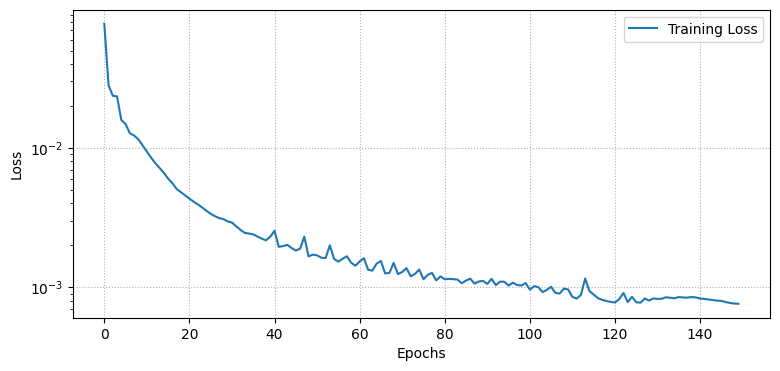

In [57]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

def create_train_state(rng, learning_rate, model, x):
    params = model.init(rng, x)
    tx = optax.sgd(learning_rate, momentum=0.2)
    return train_state.TrainState.create(apply_fn=model.apply, params=params, tx=tx)

def mse_loss(params, batch, model):
    def loss_fn(params):
        reconstruction = model.apply(params, batch)
        return jnp.mean((batch - reconstruction) ** 2)
    return jax.value_and_grad(loss_fn)(params)

@jax.jit
def train_step(state, batch):
    loss, grads = mse_loss(state.params, batch, Autoencoder())
    state = state.apply_gradients(grads=grads)
    return state, loss

# Set training parameters
n_epochs = 150
batch_size = 128
learning_rate = 3e-2 # 3e-2

# Initialize model and state
rng = jax.random.PRNGKey(0)
x = jnp.ones((batch_size, TIME_STEPS, 1))
state = create_train_state(rng, learning_rate, Autoencoder(), x)

# Training loop
losses = []

for epoch in tqdm(range(n_epochs)):
    epoch_losses = []
    for i in range(0, len(x_train), batch_size):
        x_batch = x_train[i:i + batch_size]
        if x_batch.shape[0] != batch_size:  # Skip the last batch if it is smaller than batch_size
            continue
        state, loss = train_step(state, x_batch)
        epoch_losses.append(loss)
    losses.append(np.mean(epoch_losses))

# Plot the training loss curve
plt.figure(figsize=(9, 4))
plt.semilogy(losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(linestyle=":")
plt.legend()
plt.show()

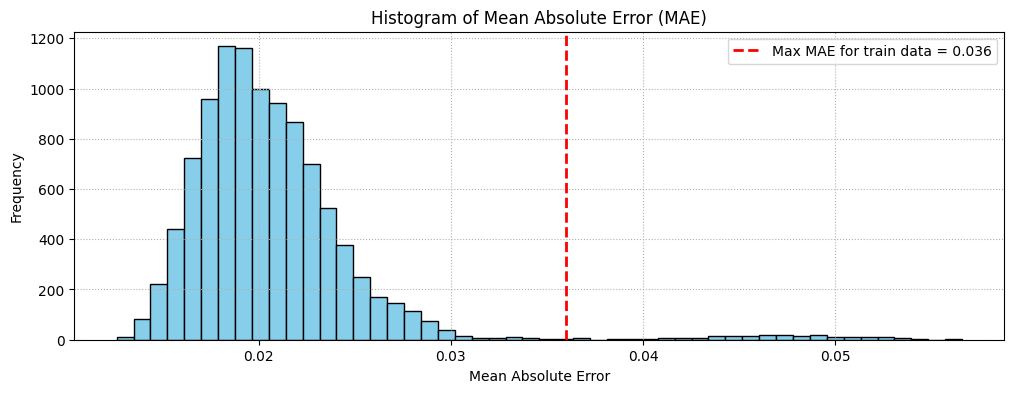

In [58]:
import matplotlib.pyplot as plt
import jax.numpy as jnp

# Function to calculate MAE
def calculate_mae(params, data, model):
    reconstructed = model.apply(params, data)
    mae = jnp.mean(jnp.abs(data - reconstructed), axis=(1, 2))
    return mae

# Calculate MAE for x_train
mae_train = calculate_mae(state.params, x_train, Autoencoder())
treshold = jnp.max(mae_train)

# Calculate MAE for x_full
mae_full = calculate_mae(state.params, x_full, Autoencoder())

# Plot histogram of MAE for x_full
plt.figure(figsize=(12, 4))
plt.hist(mae_full, bins=50, color='skyblue', edgecolor='black')
plt.axvline(treshold, color='red', linestyle='dashed', linewidth=2, label=f'Max MAE for train data = {treshold:.3f}')
plt.xlabel('Mean Absolute Error')
plt.ylabel('Frequency')
plt.title('Histogram of Mean Absolute Error (MAE)')
plt.legend()
plt.grid(linestyle=":")
plt.show()


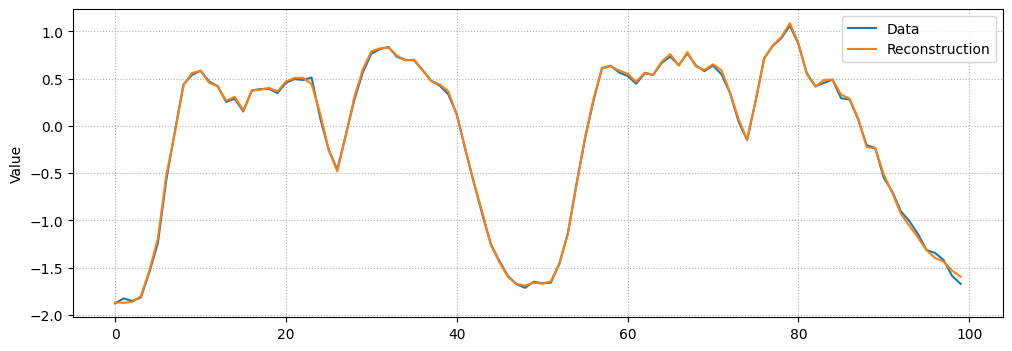

In [59]:
# Checking how the first sequence is learnt
index = np.random.randint(len(x_full))

plt.figure(figsize=(12, 4))
plt.plot(x_full[index], label="Data")
prediction =  model.apply(state.params, x_full[index])
plt.plot(prediction, label="Reconstruction")
plt.ylabel("Value")
plt.xlabel("")
plt.legend()
plt.grid(linestyle=":")
plt.show()

In [60]:
import plotly.graph_objs as go
import pandas as pd
import numpy as np

# Load the dataset
# url = "https://raw.githubusercontent.com/numenta/NAB/master/data/realKnownCause/nyc_taxi.csv"
# df = pd.read_csv(url, parse_dates=True, index_col="timestamp")
# df_normalized = df
# df_normalized['value'] = (df['value'] - df['value'].mean()) / df['value'].std()

# Define the anomalies
anomalies = {
    "NYC Marathon": "2014-11-02 01:00",
    "Thanksgiving": "2014-11-27 16:30",
    "Christmas": "2014-12-25 16:30",
    "New Year's Day": "2015-01-01 01:00",
    "Snow Storm": "2015-01-27 13:30"
}

# Create the plot
fig = go.Figure()

# Add the main trace
fig.add_trace(go.Scatter(x=df_normalized.index, y=df_normalized['value'], mode='lines', name='Taxi Passengers'))

# Add anomaly points with unique markers
marker = 'square'
for (label, date) in anomalies.items():
    fig.add_trace(go.Scatter(
        x=[date],
        y=[df_normalized.loc[date]['value']],
        mode='markers+text',
        name=label,
        text=label,
        textposition="top center",
        marker=dict(symbol=marker, size=10, color='red')
    ))
    
anomaly_indices = np.where(mae_full > treshold)[0]

# Add predicted anomalies with red markers
for i in anomaly_indices:
    date = df_normalized.index[int(i + TIME_STEPS/2)]
    fig.add_trace(go.Scatter(
        x=[date],
        y=[df_normalized.loc[date]['value']],
        mode='markers',
        name='Predicted Anomaly' if i == anomaly_indices[0] else None,
        legendgroup='Predicted Anomaly',
        marker=dict(symbol='x', size=10, color='green'),
        showlegend = bool(i == anomaly_indices[0]),
    ))

# Update layout
fig.update_layout(
    title='New York City Taxi Passengers with Anomalies Highlighted',
    xaxis_title='Date',
    template='plotly_white'
)

# Show the figure
plotly_config = {
    'displaylogo': False,
    'toImageButtonOptions': {
        'format': 'svg', # one of png, svg, jpeg, webp
        'filename': 'fmin',
        'height': None,
        'width': None,
        'scale': 1 # Multiply title/legend/axis/canvas sizes by this factor
    },
    'modeBarButtonsToRemove': ['select2d', 'lasso2d'],
    'modeBarButtonsToAdd': [
                            'drawopenpath',
                            'eraseshape'
                            ]
}

# Show the figure with the specified config
fig.show(config=plotly_config)

fig.write_html(
    "./anomaly_detection.html",
    config=plotly_config,
    include_plotlyjs="cdn",
    full_html=False,
)

#### Adadelta

100%|██████████| 100/100 [01:12<00:00,  1.37it/s]


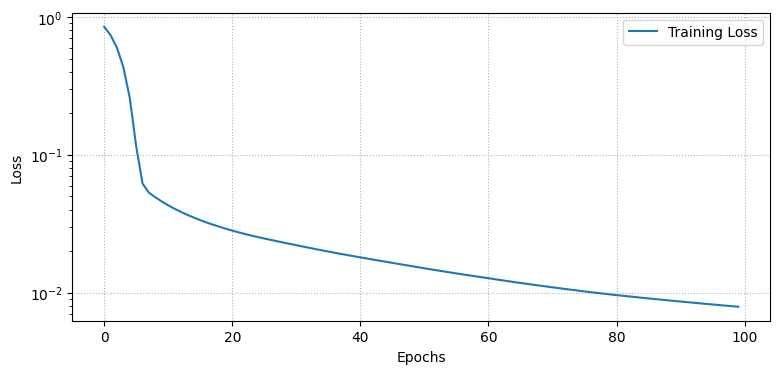

In [61]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

def create_train_state(rng, learning_rate, model, x):
    params = model.init(rng, x)
    tx = optax.adadelta(learning_rate)
    return train_state.TrainState.create(apply_fn=model.apply, params=params, tx=tx)

def mse_loss(params, batch, model):
    def loss_fn(params):
        reconstruction = model.apply(params, batch)
        return jnp.mean((batch - reconstruction) ** 2)
    return jax.value_and_grad(loss_fn)(params)

@jax.jit
def train_step(state, batch):
    loss, grads = mse_loss(state.params, batch, Autoencoder())
    state = state.apply_gradients(grads=grads)
    return state, loss

# Set training parameters
n_epochs = 100
batch_size = 128
learning_rate = 3e-3

# Initialize model and state
rng = jax.random.PRNGKey(0)
x = jnp.ones((batch_size, TIME_STEPS, 1))
state = create_train_state(rng, learning_rate, Autoencoder(), x)

# Training loop
losses = []

for epoch in tqdm(range(n_epochs)):
    epoch_losses = []
    for i in range(0, len(x_train), batch_size):
        x_batch = x_train[i:i + batch_size]
        if x_batch.shape[0] != batch_size:  # Skip the last batch if it is smaller than batch_size
            continue
        state, loss = train_step(state, x_batch)
        epoch_losses.append(loss)
    losses.append(np.mean(epoch_losses))

# Plot the training loss curve
plt.figure(figsize=(9, 4))
plt.semilogy(losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(linestyle=":")
plt.legend()
plt.show()

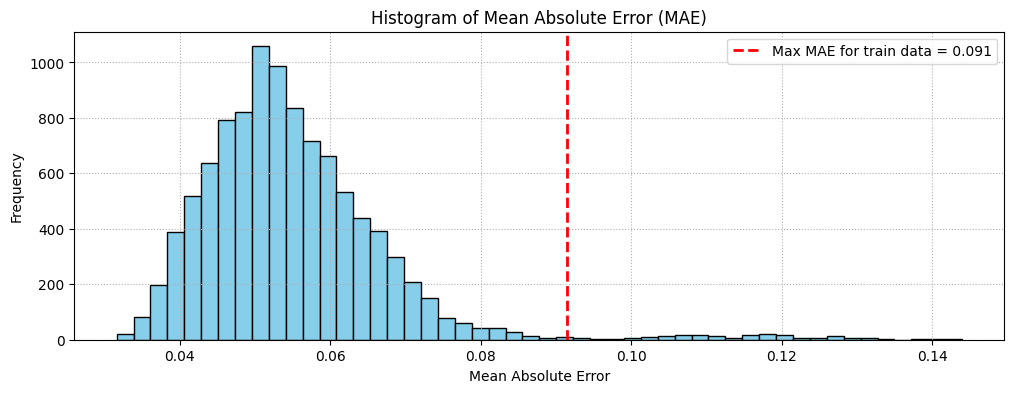

In [62]:
import matplotlib.pyplot as plt
import jax.numpy as jnp

# Function to calculate MAE
def calculate_mae(params, data, model):
    reconstructed = model.apply(params, data)
    mae = jnp.mean(jnp.abs(data - reconstructed), axis=(1, 2))
    return mae

# Calculate MAE for x_train
mae_train = calculate_mae(state.params, x_train, Autoencoder())
treshold = jnp.max(mae_train)

# Calculate MAE for x_full
mae_full = calculate_mae(state.params, x_full, Autoencoder())

# Plot histogram of MAE for x_full
plt.figure(figsize=(12, 4))
plt.hist(mae_full, bins=50, color='skyblue', edgecolor='black')
plt.axvline(treshold, color='red', linestyle='dashed', linewidth=2, label=f'Max MAE for train data = {treshold:.3f}')
plt.xlabel('Mean Absolute Error')
plt.ylabel('Frequency')
plt.title('Histogram of Mean Absolute Error (MAE)')
plt.legend()
plt.grid(linestyle=":")
plt.show()

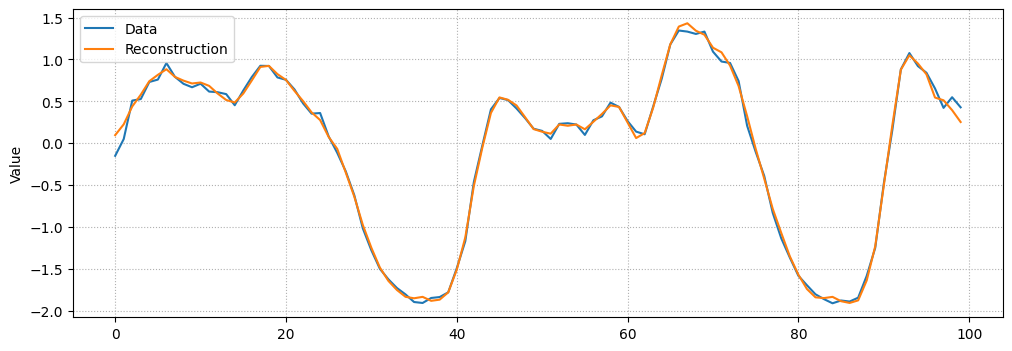

In [63]:
# Checking how the first sequence is learnt
index = np.random.randint(len(x_full))

plt.figure(figsize=(12, 4))
plt.plot(x_full[index], label="Data")
prediction =  model.apply(state.params, x_full[index])
plt.plot(prediction, label="Reconstruction")
plt.ylabel("Value")
plt.xlabel("")
plt.legend()
plt.grid(linestyle=":")
plt.show()

In [64]:
import plotly.graph_objs as go
import pandas as pd
import numpy as np

# Load the dataset
# url = "https://raw.githubusercontent.com/numenta/NAB/master/data/realKnownCause/nyc_taxi.csv"
# df = pd.read_csv(url, parse_dates=True, index_col="timestamp")
# df_normalized = df
# df_normalized['value'] = (df['value'] - df['value'].mean()) / df['value'].std()

# Define the anomalies
anomalies = {
    "NYC Marathon": "2014-11-02 01:00",
    "Thanksgiving": "2014-11-27 16:30",
    "Christmas": "2014-12-25 16:30",
    "New Year's Day": "2015-01-01 01:00",
    "Snow Storm": "2015-01-27 13:30"
}

# Create the plot
fig = go.Figure()

# Add the main trace
fig.add_trace(go.Scatter(x=df_normalized.index, y=df_normalized['value'], mode='lines', name='Taxi Passengers'))

# Add anomaly points with unique markers
marker = 'square'
for (label, date) in anomalies.items():
    fig.add_trace(go.Scatter(
        x=[date],
        y=[df_normalized.loc[date]['value']],
        mode='markers+text',
        name=label,
        text=label,
        textposition="top center",
        marker=dict(symbol=marker, size=10, color='red')
    ))
    
anomaly_indices = np.where(mae_full > treshold)[0]

# Add predicted anomalies with red markers
for i in anomaly_indices:
    date = df_normalized.index[int(i + TIME_STEPS/2)]
    fig.add_trace(go.Scatter(
        x=[date],
        y=[df_normalized.loc[date]['value']],
        mode='markers',
        name='Predicted Anomaly' if i == anomaly_indices[0] else None,
        legendgroup='Predicted Anomaly',
        marker=dict(symbol='x', size=10, color='green'),
        showlegend = bool(i == anomaly_indices[0]),
    ))

# Update layout
fig.update_layout(
    title='New York City Taxi Passengers with Anomalies Highlighted',
    xaxis_title='Date',
    template='plotly_white'
)

# Show the figure
plotly_config = {
    'displaylogo': False,
    'toImageButtonOptions': {
        'format': 'svg', # one of png, svg, jpeg, webp
        'filename': 'fmin',
        'height': None,
        'width': None,
        'scale': 1 # Multiply title/legend/axis/canvas sizes by this factor
    },
    'modeBarButtonsToRemove': ['select2d', 'lasso2d'],
    'modeBarButtonsToAdd': [
                            'drawopenpath',
                            'eraseshape'
                            ]
}

# Show the figure with the specified config
fig.show(config=plotly_config)

fig.write_html(
    "./anomaly_detection.html",
    config=plotly_config,
    include_plotlyjs="cdn",
    full_html=False,
)

#### BFGS

In [7]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

def create_train_state(rng, learning_rate, model, x):
    params = model.init(rng, x)
    tx = optax.lbfgs(learning_rate)
    return train_state.TrainState.create(apply_fn=model.apply, params=params, tx=tx)

def mse_loss(params, batch, model):
    def loss_fn(params):
        reconstruction = model.apply(params, batch)
        return jnp.mean((batch - reconstruction) ** 2)
    return jax.value_and_grad(loss_fn)(params)

@jax.jit
def train_step(state, batch):
    loss, grads = mse_loss(state.params, batch, Autoencoder())
    state = state.apply_gradients(grads=grads)
    return state, loss

# Set training parameters
n_epochs = 100
batch_size = 128
learning_rate = 1e-3

# Initialize model and state
rng = jax.random.PRNGKey(0)
x = jnp.ones((batch_size, TIME_STEPS, 1))
state = create_train_state(rng, learning_rate, Autoencoder(), x)

# Training loop
losses = []

for epoch in tqdm(range(n_epochs)):
    epoch_losses = []
    for i in range(0, len(x_train), batch_size):
        x_batch = x_train[i:i + batch_size]
        if x_batch.shape[0] != batch_size:  # Skip the last batch if it is smaller than batch_size
            continue
        state, loss = train_step(state, x_batch)
        epoch_losses.append(loss)
    losses.append(np.mean(epoch_losses))

# Plot the training loss curve
plt.figure(figsize=(9, 4))
plt.semilogy(losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(linestyle=":")
plt.legend()
plt.show()

  0%|          | 0/100 [00:00<?, ?it/s]


TypeError: scale_by_zoom_linesearch.<locals>.update_fn() missing 3 required keyword-only arguments: 'value', 'grad', and 'value_fn'

In [ ]:
import matplotlib.pyplot as plt
import jax.numpy as jnp

# Function to calculate MAE
def calculate_mae(params, data, model):
    reconstructed = model.apply(params, data)
    mae = jnp.mean(jnp.abs(data - reconstructed), axis=(1, 2))
    return mae

# Calculate MAE for x_train
mae_train = calculate_mae(state.params, x_train, Autoencoder())
treshold = jnp.max(mae_train)

# Calculate MAE for x_full
mae_full = calculate_mae(state.params, x_full, Autoencoder())

# Plot histogram of MAE for x_full
plt.figure(figsize=(12, 4))
plt.hist(mae_full, bins=50, color='skyblue', edgecolor='black')
plt.axvline(treshold, color='red', linestyle='dashed', linewidth=2, label=f'Max MAE for train data = {treshold:.3f}')
plt.xlabel('Mean Absolute Error')
plt.ylabel('Frequency')
plt.title('Histogram of Mean Absolute Error (MAE)')
plt.legend()
plt.grid(linestyle=":")
plt.show()

In [ ]:
# Checking how the first sequence is learnt
index = np.random.randint(len(x_full))

plt.figure(figsize=(12, 4))
plt.plot(x_full[index], label="Data")
prediction =  model.apply(state.params, x_full[index])
plt.plot(prediction, label="Reconstruction")
plt.ylabel("Value")
plt.xlabel("")
plt.legend()
plt.grid(linestyle=":")
plt.show()

In [ ]:
import plotly.graph_objs as go
import pandas as pd
import numpy as np

# Load the dataset
# url = "https://raw.githubusercontent.com/numenta/NAB/master/data/realKnownCause/nyc_taxi.csv"
# df = pd.read_csv(url, parse_dates=True, index_col="timestamp")
# df_normalized = df
# df_normalized['value'] = (df['value'] - df['value'].mean()) / df['value'].std()

# Define the anomalies
anomalies = {
    "NYC Marathon": "2014-11-02 01:00",
    "Thanksgiving": "2014-11-27 16:30",
    "Christmas": "2014-12-25 16:30",
    "New Year's Day": "2015-01-01 01:00",
    "Snow Storm": "2015-01-27 13:30"
}

# Create the plot
fig = go.Figure()

# Add the main trace
fig.add_trace(go.Scatter(x=df_normalized.index, y=df_normalized['value'], mode='lines', name='Taxi Passengers'))

# Add anomaly points with unique markers
marker = 'square'
for (label, date) in anomalies.items():
    fig.add_trace(go.Scatter(
        x=[date],
        y=[df_normalized.loc[date]['value']],
        mode='markers+text',
        name=label,
        text=label,
        textposition="top center",
        marker=dict(symbol=marker, size=10, color='red')
    ))
    
anomaly_indices = np.where(mae_full > treshold)[0]

# Add predicted anomalies with red markers
for i in anomaly_indices:
    date = df_normalized.index[int(i + TIME_STEPS/2)]
    fig.add_trace(go.Scatter(
        x=[date],
        y=[df_normalized.loc[date]['value']],
        mode='markers',
        name='Predicted Anomaly' if i == anomaly_indices[0] else None,
        legendgroup='Predicted Anomaly',
        marker=dict(symbol='x', size=10, color='red'),
        showlegend = bool(i == anomaly_indices[0]),
    ))

# Update layout
fig.update_layout(
    title='New York City Taxi Passengers with Anomalies Highlighted',
    xaxis_title='Date',
    template='plotly_white'
)

# Show the figure
plotly_config = {
    'displaylogo': False,
    'toImageButtonOptions': {
        'format': 'svg', # one of png, svg, jpeg, webp
        'filename': 'fmin',
        'height': None,
        'width': None,
        'scale': 1 # Multiply title/legend/axis/canvas sizes by this factor
    },
    'modeBarButtonsToRemove': ['select2d', 'lasso2d'],
    'modeBarButtonsToAdd': [
                            'drawopenpath',
                            'eraseshape'
                            ]
}

# Show the figure with the specified config
fig.show(config=plotly_config)

fig.write_html(
    "./anomaly_detection.html",
    config=plotly_config,
    include_plotlyjs="cdn",
    full_html=False,
)

### Big models

#### 1. Fit the largest model you can on a single GPU. [20 points]

| Setup | # of parameters | GPU peak memory, MB | Final eval loss|Batch Size|Time to run 5 epochs|Generation example|Comment
| --- | ----------- |   ----------- |----------- |----------- |----------- |----------- |----------- |
|Baseline (GPT2-S)	|124 M	|13016	|2.001	|8	|487.75	|A long time ago in a galaxy far far away... a little girl named Lily was playing in the garden. She was so excited! She wanted to explore the garden and see what was around her. Suddenly, she heard a loud noise. Lily looked up and saw a big, hairy creature. Lily was so excited! She ran to the creature and grabbed it by the arm. The creature was so big and hairy that Lily couldn't help but laugh.	| -|
| Baseline (GPT2-S) | 124 M | 15310 |2.008286952972412 |10 |494.1773 |A long time ago in a galaxy far far away... a little girl named Lily was playing in the garden. She was so excited! She wanted to explore the garden and see what was out there.Suddenly, she heard a loud noise. Lily looked around and saw a big, dark, dark room. She looked around and saw a big, dark, dark room. Lily was so excited! She ran to the door and opened it. She saw a big, dark, dark room.| Повысил батч, больше не влезало
| Baseline (GPT2-S) | 124 M |13244 |2.0453531742095947 |10 |482.2874 |A long time ago in a galaxy far far away... a young girl named Lily was playing with her friends. She was so excited! She wanted to play with her friends and play with her toys. She was so excited! She was so happy! Lily was so happy to be playing with her friends!Lily was so happy to be playing with her friends! She was so happy to be playing with her toys! She was so happy to be playing with her toys! She was so| Добавил gradient accumulation
| Baseline (GPT2-S) | 124 M | 7171| 2.0063040256500244 |10 | 494.6584|A long time ago in a galaxy far far away... a little girl named Lily was playing in the garden. She was so excited! She wanted to explore the garden and see what was out there.Suddenly, she heard a loud noise. Lily looked around and saw a big, dark, dark room. She looked around and saw a big, dark, dark room. Lily was so excited! She ran to the door and opened it. She saw a big, dark, dark room.| Добавил gradient checkpointing
| Baseline (GPT2-S) | 124 M | 5274| 2.0404553413391113 |10 | 266.6715 |A long time ago in a galaxy far far away... a young girl named Lily was playing with her friends. She was so excited! She was so excited to play with her friends! Lily was so happy! She was so happy to be able to play with her friends!Lily was so happy to be able to play with her friends! She was so happy to be able to play with her friends! She was so happy to be able to play with her friends!| Ко всем прошлым добавил adafactor
| Baseline (GPT2-S) | 124 M |6655 | 2.013160467147827 |10 | 331.62 |A long time ago in a galaxy far far away... a little girl named Lily was playing in the garden. She was so excited! She wanted to explore the garden and see what was out there.Suddenly, she heard a loud noise. Lily looked around and saw a big, dark, dark room. She looked around and saw a big, dark, dark room. Lily was so excited! She ran to the door and opened it. She saw a big, dark, dark room.| Применил 8-bit Adam
| GPT2-M | 350 M |9422 | 1.7607312202453613 |8 | 708.41 |A long time ago in a galaxy far far away... there was a little girl named Lily. She was very curious and wanted to know everything there was to know about the universe. One day, Lily was walking in the park when she saw a big, shiny, shiny object. She was so excited and asked her mom, "Mom, can I touch it?" Her mom smiled and said, "Of course, Lily. It's a toy!"| Применил gradient checkpointing
| GPT2-M | 350 M | 9645| 1.7653889656066895 |16 | 928.05 |A long time ago in a galaxy far far away... there was a little girl named Lily. She was very curious and wanted to know everything about the universe. One day, she went to visit her mom. She was so excited to see the universe. When Lily arrived at her mom's house, she saw a big, shiny, red ball. Lily was so excited to see it. She ran to it and started to play with it.| Применил gradient checkpointing и увеличил батч до 16
| GPT2-M | 350 M | 14472 | 1.7787549495697021 |8 | 655.25 |A long time ago in a galaxy far far away...There was a little girl named Alice. She was very curious and wanted to know everything about the universe. She wanted to know everything about the stars, the planets, the galaxies and the universe.One day, Alice was playing in the garden when she saw a big, shiny, shiny ball. She was so excited! She ran to it and started to play with it.Suddenly, she heard a voice. | Применил gradient checkpointing и gradient accumulation
| GPT2-M | 350 M | 7211 | 1.7685070037841797 |16 | 929.71 |A long time ago in a galaxy far far away... there was a little girl named Lily. She was very curious and wanted to know everything about the universe. One day, she went to visit her mom. She was so excited to see the universe. When Lily arrived at her mom's house, she saw a big, shiny, red ball. Lily was so excited to see it. She ran to it and started to play with it.| Применил gradient checkpointing и 8-bit Adam
| GPT2-M | 350 M | 10152 | 1.75977623462677 |8 | 722.53 |A long time ago in a galaxy far far away... there was a little girl named Lily. She was three years old and loved to play outside. One day, she saw a big, shiny, shiny ball. She wanted to play with it, so she ran to it. Lily ran to the ball and started to play with it. She was so excited! She ran around the ball, jumping and spinning it around. | Применил gradient checkpointing и adafactor
| opt-1.3b | 1315758080 | 14571 | 1.989353060722351 |1 | 3364.71 |A long time ago in a galaxy far far away... there was a little planet called Earth. It was a very special planet, because it had a sun and it had a moon. The sun and the moon were very happy together, because they made a great big planet to live on.Every day, the sun and the moon would play together in the sky. The sun would shine and the moon would shine back, and it was so much fun! | Применил gradient checkpointing, gradient accumulation, fp16 и 8-bit Adam

